In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score, RandomizedSearchCV, TunedThresholdClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, fbeta_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

# Imbalance Dataset
from imblearn.pipeline import Pipeline

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Save Best Model
import pickle

import shap

from datetime import datetime

# Set max columns
pd.set_option('display.max_columns', None)

## BUSINESS PROBLEM UNDERSTANDING

### Business Understanding: Maximizing RevPAR through Intelligent Management of Booking Cancellations

## 1. Context & Business Background

### Profil Bisnis Hotel

Berdasarkan karakteristik pada dataset yang dianalisis, objek bisnis dalam studi kasus ini merupakan sebuah hotel berbintang yang berlokasi di kawasan perkotaan Portugal. Hotel ini beroperasi dengan model bisnis high–volume transient hotel, yaitu tipe hotel yang mengandalkan perputaran tamu yang cepat dengan durasi menginap relatif pendek (short stay), umumnya 1–3 malam. Segmentasi tamu utamanya terdiri dari wisatawan bisnis, city-break tourist, serta tamu yang melakukan perjalanan singkat pada hari kerja maupun akhir pekan.

Sebagai hotel elit di perkotaan, strategi komersial utama adalah memaksimalkan okupansi harian dan stabilitas pendapatan kamar. Hotel menjual kamar melalui berbagai kanal reservasi seperti online travel agent (OTA), website resmi, hingga agen perjalanan dan corporate contract. Produk utama yang dijual adalah ketersediaan kamar per malam yang bersifat perishable: apabila kamar tidak terjual pada tanggal tertentu, pendapatan pada malam tersebut hilang dan tidak dapat dipulihkan di kemudian hari yang artinya kesempatan untuk mendapatkan pendapatannya gak sama sekali balik pada satu kesempatan tersebut.

Dalam menjalankan operasional reservasi, hotel menerapkan prinsip first-come, first-served, di mana kamar dialokasikan terlebih dahulu kepada tamu yang lebih dulu melakukan pemesanan dan konfirmasi. Artinya, ketika sebuah booking tercatat di sistem, kamar pada tanggal tersebut akan “dipasangkan” kepada tamu tersebut dan tidak dapat lagi dijual ke tamu lain, kecuali hotel menerapkan strategi overbooking yang terukur. Pada konteks inilah, pembatalan (cancellation) dan no-show menjadi sangat krusial: ketika tamu yang sudah memegang “jatah kamar” membatalkan mendekati tanggal menginap, hotel sering kali sudah terlambat untuk menjual kembali kamar tersebut kepada calon tamu lain.

Dataset historis yang digunakan dalam analisis ini mencakup lebih dari 83.000 transaksi pemesanan kamar, yang menggambarkan tingginya aktivitas reservasi harian dan dinamika keluar–masuknya tamu. Volume transaksi yang besar tersebut menunjukkan bahwa hotel sangat bergantung pada efisiensi sistem reservasi, akurasi prediksi permintaan, dan manajemen inventori kamar untuk menjaga tingkat okupansi yang optimal serta meminimalkan potensi kehilangan pendapatan akibat pembatalan.

Karakteristik Operasional Utama

Secara operasional, hotel ini memiliki beberapa karakteristik penting:

1. High Volume & High Turnover

Hotel menangani puluhan ribu pemesanan dengan tingkat pergantian tamu yang cepat. Mayoritas tamu bersifat transient, sehingga keputusan reservasi dan pembatalan sering terjadi dalam waktu yang relatif singkat.

2. Ketergantungan Tinggi pada Online Travel Agent (OTA)

Distribusi pemesanan didominasi oleh kanal Online Travel Agent (OTA) seperti Booking.com dan Expedia. OTA memberikan keuntungan berupa volume pemesanan yang tinggi, namun di sisi lain juga membawa risiko besar karena:

Loyalitas pelanggan cenderung rendah
Proses pembatalan sangat mudah
Tamu sering melakukan pemesanan tanpa komitmen finansial awal

3. Segmentasi Pasar yang Beragam

Hotel melayani berbagai segmen pelanggan, mulai dari:

Transient & Transient-Party (individu dan keluarga kecil)
Corporate (tamu bisnis dengan stabilitas lebih tinggi)
Groups & Contract (jumlah kecil namun biasanya lebih terencana)


Perbedaan karakteristik antar segmen ini menciptakan variasi risiko pembatalan yang signifikan, sehingga pendekatan manajemen reservasi “satu aturan untuk semua” menjadi kurang efektif.
Konsep Utama: Perishable Inventory
Dalam industri perhotelan, kamar hotel dikategorikan sebagai perishable inventory, yaitu aset yang memiliki batas waktu jual yang absolut.
Artinya:

* Kamar yang tersedia pada malam tertentu tidak dapat disimpan untuk dijual di hari berikutnya.
* Jika kamar tidak terjual atau kosong pada hari-H, maka potensi pendapatan dari kamar tersebut hilang secara permanen.

Oleh karena itu, tujuan utama manajemen hotel bukan hanya menjual kamar, tetapi memastikan kamar terisi pada waktu yang tepat. Indikator utama keberhasilan ini dikenal sebagai Revenue per Available Room (RevPAR).
Pain Point Utama: Tingginya Tingkat Pembatalan
Analisis data historis menunjukkan bahwa hotel menghadapi masalah serius berupa tingkat pembatalan yang sangat tinggi, yaitu sekitar 37% dari total pemesanan. Angka ini menciptakan ketidakpastian besar dalam pengelolaan inventori kamar.
Masalah ini memunculkan dua risiko utama yang saling bertolak belakang:

1. Inventory Spoilage (Kamar Kosong)
Hotel sering kali terlihat fully booked jauh sebelum tanggal check-in. Akibatnya, hotel menolak pemesanan baru dan itulah mengapa sistem first come first disini cukup kuat melihat booking terhitung dari sejak jauh hari. Namun, mendekati hari-H, sebagian besar pemesanan tersebut dibatalkan secara mendadak. Karena waktu sudah terlalu dekat dan kamar tersebut belum langsung siap untuk dialihkan ke pelanggan selanjutnya, maka kamar-kamar tersebut tidak sempat dijual kembali dan akhirnya kosong.
Kondisi ini menyebabkan:

* Kehilangan pendapatan kamar
* Hilangnya potensi pendapatan tambahan (F&B, layanan hotel)
* Revenue leakage yang tidak dapat dipulihkan

2. Inventory Spill (Opportunity Loss)
Sebaliknya, ketakutan terhadap overbooking membuat hotel terlalu konservatif. Hotel menahan inventori kamar demi menghindari risiko tamu berlebih. Padahal, sebagian pemesanan tersebut memiliki probabilitas tinggi untuk dibatalkan.
Akibatnya:

* Hotel kehilangan kesempatan menjual kamar kepada tamu lain
* Potensi harga lebih tinggi (yield management) tidak tercapai
* Permintaan pasar tidak dimanfaatkan secara optimal

Keterbatasan Strategi Saat Ini
Dalam praktiknya, hotel cenderung menggunakan kebijakan overbooking statis, misalnya:

“Menjual 105 kamar untuk kapasitas 100 kamar.”

Pendekatan ini memiliki kelemahan besar:

* Tidak mempertimbangkan profil risiko masing-masing tamu
* Mengabaikan variasi perilaku antar segmen
* Berisiko menimbulkan biaya tinggi jika prediksi meleset

Jika terlalu agresif, hotel harus melakukan “Walk the Guest”, yaitu memindahkan tamu ke hotel mitra dengan biaya kompensasi, transportasi, dan potensi kerusakan reputasi.
Kebutuhan Bisnis: Dari Reactive ke Predictive
Berdasarkan kondisi tersebut, hotel membutuhkan pendekatan yang lebih cerdas dan adaptif. Bukan sekadar mengandalkan angka rata-rata historis, tetapi menggunakan data-driven prediction.
Dengan memanfaatkan Machine Learning, hotel dapat:

* Memprediksi probabilitas pembatalan sejak awal pemesanan
* Mengelola overbooking secara dinamis dan terukur
* Menyeimbangkan antara risiko kamar kosong dan biaya overbooking

Pendekatan ini diharapkan mampu mentransformasi strategi reservasi hotel dari reactive management menjadi predictive analytics, sehingga keputusan bisnis menjadi lebih akurat, terukur, dan selaras dengan tujuan utama: memaksimalkan RevPAR tanpa mengorbankan profitabilitas jangka panjang.

## 2. Problem Definition

### Context & Stakeholders
1. **Revenue Manager**: Ingin memaksimalkan *Occupancy Rate* di masa *High Demand* (permintaan tinggi).
2. **Reservation Team**: Bertanggung jawab mengelola *inventory* kamar agar tidak ada kamar yang terbuang percuma (*spoiled*).
3. **Front Office**: Siap menangani tamu limpahan (*walk the guest*) jika terjadi overbooking.

### The Problem (Masalah Spesifik)
Hotel mengalami tingkat pembatalan pesanan yang tinggi (**37%**). Dalam kondisi *High Season*, kamar yang batal mendadak seringkali berakhir kosong karena hotel terlambat menjualnya kembali.
1.  **Revenue Leakage (Kamar Kosong):** Masalah terbesar. Setiap kamar kosong adalah kerugian pendapatan yang tidak tergantikan.
2.  **Conservative Loss:** Ketakutan berlebihan terhadap overbooking menyebabkan hotel kehilangan potensi cuan dari tamu *waiting list*.

2. Business Goal & Objective
Tujuan utama dari proyek Machine Learning ini adalah mentransformasi strategi reservasi hotel dari Reactive menjadi Predictive Analytics.
Objective:
Membangun model klasifikasi (Supervised Learning) yang mampu memprediksi probabilitas seorang tamu akan membatalkan pesanan (is_canceled = 1) segera setelah booking dibuat.
Strategic Application (Intelligent Overbooking):
Hasil prediksi model akan digunakan oleh Revenue Manager untuk:

1. Dynamic Inventory Release: Jika sebuah booking diprediksi High Risk Cancel, sistem akan secara otomatis membuka kembali slot ketersediaan kamar di OTA untuk dijual ke tamu lain.
2. Mitigation Action: Untuk booking yang berisiko batal tapi belum tentu batal, tim reservasi bisa melakukan tindakan preventif, seperti mengirim email konfirmasi ulang atau meminta deposit parsial.

Dengan strategi ini, hotel menargetkan:

* Minimasi Kamar Kosong (False Negative): Menangkap peluang pendapatan yang sebelumnya hilang.
* Kontrol Biaya Overbooking (False Positive): Menjaga agar jumlah tamu yang dipindahkan (walked guests) tetap dalam batas toleransi wajar yang tidak merugikan profitabilitas keseluruhan.

### Goals (Target Terukur)
Tujuan dari model Machine Learning ini adalah mendukung strategi **Aggressive Overbooking**:
*   **Primary Goal:** Memprediksi status booking (`is_canceled`) untuk segera menjual kembali kamar tersebut ke tamu lain.
*   **Measurable Metrics:** Fokus pada **Recall** tinggi (menggunakan **F2 Score**) untuk menangkap sebanyak mungkin pembatalan, dengan toleransi tertentu terhadap risiko overbooking.

---

## 3. Business Value & Cost-Benefit Analysis

**Skenario Bisnis:** *High Season / Peak Period*.
Asumsi Harga Kamar (*Opportunity Loss*) melonjak menjadi **\$200**. Hotel memiliki mitra kerjasama untuk menampung kelebihan tamu dengan biaya murah (*Contract Rate*).

| Actual \ Predicted | <span style="color:red">**Predicted Cancel (1)**</span> | <span style="color:blue">**Predicted Not Cancel (0)**</span> |
| :--- | :--- | :--- |
| **Actual Cancel (1)** | **True Positive (TP)**<br><span style="color:green">**Benefit: $0**</span><br>**Action**: Hotel menjual ulang kamar ke tamu baru (Overbooking).<br>**Impact**: Pendapatan maksimal terjaga (*Revenue Secured*). | **False Negative (FN)**<br><span style="color:red">**Cost: -\$200**</span><br>**Action**: Kita diam saja ketika tamu membatalkan pesananan booking kamar yang akhirnya kamar kosong tanpa pengganti tamu baru sehingga kesempatan kamar terisi pun nihil dan malah merugi.<br>**Loss**: **MAJOR LOSS**. Kehilangan pendapatan High Season (di musim liburan atau Q4 akhir tahun) + kehilangan potensi F&B income. |
| **Actual Not Cancel (0)** | **False Positive (FP)**<br><span style="color:darkorange">**Cost: -\$75 (Risiko Overbooked)**</span><br>**Scenario**: Kita prediksi batal & jual kamarnya, ternyata tamu asli datang.<br>**Impact**: Hotel melakukan **"Walk the Guest"** ke hotel mitra.<br>**Loss**: Biaya selisih harga kamar mitra + Transportasi (Diasumsikan lebih murah dibanding kehilangan Revenue penuh). | **True Negative (TN)**<br><span style="color:blue">**Benefit: \$0**</span><br>**Impact**: Operasional berjalan normal. Tamu datang sesuai jadwal.

### Key Insights & Strategy
1. **The Cost Trade-off (F2 Logic)**:
    *   **Cost FN (Kamar Kosong/Lost Opportunity)** = **\$200** (Sangat Mahal).
    *   **Cost FP (Walk the Guest)** = **~\$75** (Terkontrol/Lebih Murah).
    *   *Insight:* Membiarkan kamar kosong (FN) **2.7x lebih merugikan** daripada harus memindahkan tamu (FP). Oleh karena itu, kita harus agresif memprediksi batal tamu tersebut.

2. **Mitigation Strategy (Action Plan)**:
    *   Gunakan prediksi model untuk **Auto-Release Inventory**: Kamar yang diprediksi batal langsung dibuka penjualannya di OTA (Online Travel Agent).
    *   Siapkan **Mitigasi FP**: Kerjasama kontrak dengan hotel sekitar untuk menampung tamu limpahan dengan harga tetap (*Flat Rate*), sehingga biaya FP tetap rendah.

### Evaluation Metric Selection
Mengingat prioritas utama adalah menghindari kekosongan kamar (*Empty Room*):

* **Primary Metric**: **F2-Score**
    * Dalam F-Beta Score, jika Beta=2, kita memberi bobot pada **Recall** dua kali lebih besar daripada Precision.
    * **Alasan:** Kita ingin model yang "berani" memprediksi batal (meminimalkan False Negative) meskipun konsekuensinya ada sedikit kenaikan False Positive (Overbooking), karena biaya FP lebih murah.
* **Secondary Metric:** **Recall**.
    * Memastikan kita menangkap mayoritas pembatalan yang terjadi.

> **Business Goal**: **Maximizing Revenue** dengan cara meminimalkan *Spoiled Rooms* (FN), sambil menjaga biaya *Walk* (FP) dalam batas wajar.

---

## 4. ML Implementation Strategy

### Siapa Pengguna Model Ini? (The "Who")
*   **Revenue Manager**: Menggunakan prediksi untuk mengatur strategi *Overbooking Limit* harian.
*   **Front Office Manager**: Menerima peringatan dini tentang potensi jumlah tamu yang harus di-*walk* (dipindahkan) jika prediksi meleset.

### Kapan & Bagaimana Model Digunakan? (The "When")
1.  **Timing**: Model dijalankan harian untuk booking yang akan Check-In **3 - 7 hari ke depan** (Periode krusial penjualan kembali).
2.  **Workflow**:
    *   Model memberikan flag `High Probability of Cancellation`.
    *   Sistem Revenue Management secara otomatis menambah kuota kamar yang tersedia di website/OTA sejumlah prediksi tersebut.
    *   Jika tamu asli tetap datang (FP), Front Office mengeksekusi prosedur pemindahan tamu ke hotel mitra (*Walk Strategy*).

In [415]:
base_dir = "C:\\Users\\ALIF\\Documents\\Kelas JCDSBDGPM-10\\Dataset\\"

In [416]:
path = base_dir + "data_hotel_booking_demand.csv"

In [417]:
df = pd.read_csv(path)
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


### Data Understanding

Dataset ini berisi 11 kolom yang berkaitan dengan informasi data penyewa kamar hotel dari berbagai negara dengan mayoritas negara dari Portugal

### Deskripsi Fitur Dataset

Berikut adalah rincian kolom yang digunakan dalam analisis dan pemodelan:

| No. | Nama Kolom | Tipe Data | Deskripsi Kontekstual |
|:---:|:---|:---:|:---|
| 1 | **country** | `object` | Negara asal tamu yang melakukan pemesanan. Merupakan fitur kategori dengan kardinalitas tinggi (banyak nilai unik). |
| 2 | **market_segment** | `object` | Segmentasi pasar/channel pemesanan (misal: Online TA, Direct, Corporate). Tamu korporat biasanya dianggap memiliki komitmen lebih pasti dibanding tamu dari Online Travel Agent. |
| 3 | **previous_cancellations** | `int64` | Jumlah pembatalan yang pernah dilakukan tamu di masa lalu. Indikator riwayat perilaku penting; tamu yang sering membatalkan sebelumnya dianggap berisiko tinggi (*High Risk*). |
| 4 | **booking_changes** | `int64` | Jumlah perubahan yang dilakukan pada pemesanan (seperti mengubah tanggal, tipe kamar, dll) setelah booking dibuat. |
| 5 | **deposit_type** | `object` | Jenis deposit (No Deposit, Non Refund, Refundable). Tamu dengan status 'Non Refund' memiliki komitmen finansial tinggi sehingga sangat jarang membatalkan. |
| 6 | **days_in_waiting_list** | `int64` | Jumlah hari pemesanan berada dalam daftar tunggu (*waiting list*) sebelum akhirnya dikonfirmasi ke tamu. |
| 7 | **customer_type** | `object` | Tipe pelanggan (Transient, Transient-Party, Contract, Group) yang menggambarkan pola kunjungan tamu. |
| 8 | **reserved_room_type** | `object` | Kode tipe kamar yang dipesan oleh tamu (contoh: A, D, E). |
| 9 | **required_car_parking_spaces** | `int64` | Jumlah tempat parkir mobil yang diminta oleh tamu. Permintaan parkir bisa mengindikasikan kepastian kedatangan. |
| 10 | **total_of_special_requests** | `int64` | Jumlah permintaan khusus (bantal tambahan, *view*, dll). Semakin banyak/spesifik permintaan tamu, biasanya niat menginapnya semakin serius. |
| 11 | **is_canceled** | `int64` | **Variabel Target**. Menunjukkan status akhir pemesanan: <br>• `0`: Tidak Dibatalkan (Check-In) <br>• `1`: Dibatalkan (Cancel) |

Catatan: 
* kolom country ini berupa Kode negara asal tamu dalam format ISO-3, misal: PRT, GBR, FRA, DEU, dll.

In [418]:
country_columns = df["country"]

In [419]:
country_columns.value_counts()['PRT']

np.int64(34097)

mengingat negara dengan pemesanan terbanyak pada negara dengan kode PRT disini saya mengasumsikan bahwa hotel ini memang berada di portugal sebagai kawasan dari hotel tersebut dibangun.

In [420]:
df["booking_changes"].unique()

array([ 0,  1,  2,  5,  3,  4,  6,  7,  9,  8, 17, 10, 13, 12, 14, 21, 16,
       20, 15])

Hasil dari kode diatas menunjukkan bahwa sebagian besar nilai berada di angka rendah (0–4), namun terdapat juga nilai ekstrem hingga di atas 15.
Insight Penting:

* Mayoritas tamu tidak melakukan perubahan booking sama sekali (nilai 0).
* Adanya nilai ekstrem mengindikasikan sebagian kecil tamu yang sangat “tidak stabil” atau sering mengubah reservasi.
* Distribusi ini menunjukkan pola right-skewed dan zero-inflated, yang perlu diperhatikan pada tahap preprocessing dan pemilihan model.

In [421]:
df["total_of_special_requests"].unique()

array([0, 2, 1, 3, 4, 5])

In [422]:
df["required_car_parking_spaces"].unique()

array([0, 1, 2, 8, 3])

In [423]:
df["reserved_room_type"].unique()

array(['A', 'E', 'D', 'F', 'B', 'G', 'C', 'H', 'L', 'P'], dtype=object)

In [424]:
df["days_in_waiting_list"].unique()

array([  0,   3,  39,  87,  77, 215,  97, 162,  46,  79,   4,  31, 122,
        34,  57, 259,  50,  17,  32,  43,  75,  69,  44,  22, 113,  58,
        38,  65,  48, 236, 176,  25, 108,  91,  19, 160,  68,  28,  63,
        35,  42,  59,  24,   8, 183, 187,  21, 111,  56,  98, 101,  15,
        16,  47,  93,  45,  14,  70,  10,  49, 178,  99,  60,  40,  85,
       223,   6,  33, 391,  20,   1,  41, 147,  55,  80, 379, 150,  61,
       330, 174, 107,  96,  18,  62,  13,  30, 120,  27, 207,  71,   2,
        76, 125,   5,   9, 224,  53,  83,  84,  12,  73, 100,  92,  23,
        11, 105,  26, 193,   7, 165,  74, 121,  36,  64, 185])

In [425]:
df["booking_changes"].unique()

array([ 0,  1,  2,  5,  3,  4,  6,  7,  9,  8, 17, 10, 13, 12, 14, 21, 16,
       20, 15])

In [426]:
df["previous_cancellations"].unique()

array([ 0,  1, 25,  2,  3, 11, 24, 13,  6, 26, 14,  4, 19,  5, 21])

In [427]:
# Melihat daftar nilai uniknya saja (array)
df['country'].nunique()

162

jumlah negaranya terdapat 162 yang dimana penyewa kamar hotel ada dari berbagai negara

In [428]:
df["market_segment"].unique()

array(['Offline TA/TO', 'Online TA', 'Direct', 'Groups', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

terdapat array dengan isi dari kolom yang terdata 'Undefined' yang nantinya akan saya ubah menjadi 'other' demi memetakan sesuatu yang tidak diketahui kelompok segmen marketnya ke tipe lainnya

In [429]:
df["deposit_type"].unique()

array(['No Deposit', 'Non Refund', 'Refundable'], dtype=object)

In [430]:
df["customer_type"].unique()

array(['Transient-Party', 'Transient', 'Contract', 'Group'], dtype=object)

In [431]:
# Melihat daftar nilai uniknya saja (array)
df['country'].unique()

array(['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA',
       'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL',
       'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS',
       'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN',
       'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY',
       'ISR', nan, 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY',
       'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA',
       'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN',
       'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN',
       'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS',
       'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC',
       'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR',
       'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA',
       'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM',
       'KWT', 'L

In [432]:
df["country"].value_counts()

country
PRT    34097
GBR     8495
FRA     7307
ESP     5996
DEU     5116
       ...  
DMA        1
KIR        1
MYT        1
KNA        1
AIA        1
Name: count, Length: 162, dtype: int64

In [433]:
df['is_canceled'].value_counts(normalize=True)

is_canceled
0    0.631723
1    0.368277
Name: proportion, dtype: float64

In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [435]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

dari hasil kode df.info() dan df.isna().sum() disini untuk Tipe Data Sebagian besar sudah sesuai. Fitur kategorik terbaca sebagai object, dan numerik sebagai int64. Tidak ada anomali tipe data (misal angka terbaca sebagai string).
Missing Values (NaN):

* Hampir semua kolom bersih (0 missing values).
* Kecuali kolom country, yang memiliki 351 data kosong (NaN).

Tindak Lanjut: Karena jumlah missing values pada country sangat sedikit (<0.5% dari total data), disini saya berencana membuat kategori baru seperti 'Other' untuk mengisi missing values pada tahap Data Cleansing. 

Keputusan saya memilih untuk mengisi missing values tersebut dengan kategori 'other' ini tentu ada alasan strategis karena untuk:

1. Menghindari Bias (Avoid Mode Imputation Bias):
Meskipun PRT (Portugal) adalah modus (nilai yang paling sering muncul), mengisi data kosong dengan PRT berisiko menyuntikkan bias ke dalam model. Kita akan "memaksa" model percaya bahwa tamu tersebut berasal dari Portugal, padahal faktanya tidak diketahui. Jika ternyata tamu yang tidak mengisi kolom negara memiliki perilaku cancellation yang berbeda dengan tamu Portugal, imputasi modus justru akan menyesatkan pola model.

2. Informasi di Balik "Ketiadaan" (Missingness as Information):
Dalam Data Science, ketiadaan data seringkali memiliki makna tersendiri (Informative Missingness). Tamu yang negaranya tidak tercatat mungkin berasal dari sumber booking tertentu, kesalahan sistem input, atau Walk-In yang terburu-buru. Dengan melabelinya sebagai 'Unknown', kita membiarkan model mempelajari apakah kelompok "Tanpa Negara" ini memiliki kecenderungan khusus untuk membatalkan pesanan atau tidak.

3. Mempertahankan Data (Data Preservation):
Meskipun 351 baris terlihat sedikit, baris-baris tersebut masih memuat informasi berharga di kolom lain (seperti market_segment, lead_time, dll). Menghapus baris (dropping rows) hanya karena satu kolom kosong adalah pemborosan informasi yang tidak perlu.

## Data Cleansing

Pada tahap ini dilakukan penanganan terhadap nilai yang hilang (missing values) dan standarisasi kategori agar data siap untuk diproses. Langkah-langkah meliputi pengisian data kosong pada kolom negara dan perbaikan label kategori yang tidak spesifik.

In [436]:
df.duplicated().sum()

np.int64(73371)

untuk masalah duplicated disini tidak perlu adanya handling pembersihan data duplikat dikarenakan tidak adanya kolom id sebagai salah satu hal yang perlu ditangani bila ada id yang duplikat itu yang menjadi salah satu masalah dan dalam kasus ini duplikatnya hanya dari duplikat isi kolom yang sama walaupun customernya ini tentu berbeda atau bukan orang yang sama dan bisa saja pada negara yang sama ataupun tipe layanan juga tipe kostumer yang sama walaupun customernya berbeda-beda

In [437]:
# Mengisi NaN dengan string 'Other'
df['country'] = df['country'].fillna('Other')

# Cek ulang apakah masih ada NaN
print(df['country'].isnull().sum())  # Harusnya hasilnya 0

0


In [438]:
df['market_segment'] = df['market_segment'].replace('Undefined', 'Other')

disini kolom market_segment terdapat isi kolom yang bernama undefined dan saya ubah menjadi other agar tidak terlalu tabu ketika menjelaskan maksud dari undefined ini ketika tidak diketahui segmen marketnya

In [439]:
print("Unique Market Segment:", df['market_segment'].unique())

Unique Market Segment: ['Offline TA/TO' 'Online TA' 'Direct' 'Groups' 'Corporate' 'Complementary'
 'Aviation' 'Other']


In [440]:
df.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

Kolom country sudah tidak memiliki missing values yang awalnya berjumlah 351 menjadi kosong.

## Exploratory Data Analysis (EDA)

Tahap EDA ini bertujuan untuk menggali pola tersembunyi, anomali, dan hubungan antara fitur-fitur yang ada dengan target prediksi (is_canceled). Pemahaman ini krusial untuk menentukan strategi feature engineering dan pemilihan model nantinya.

## 1. Univariate Analysis (Analisis Satu Variabel)

#### a. Distribusi Target (is_canceled)

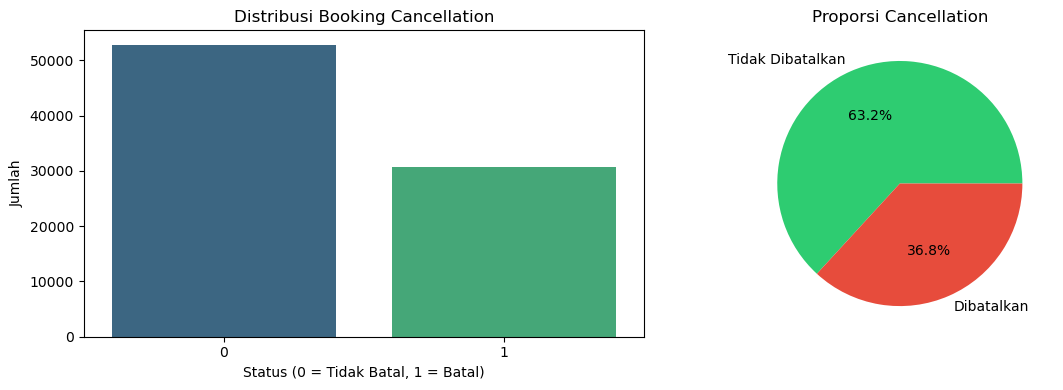

In [441]:
# Distribusi target
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(x='is_canceled', data=df, ax=ax[0], palette='viridis')
ax[0].set_title('Distribusi Booking Cancellation')
ax[0].set_xlabel('Status (0 = Tidak Batal, 1 = Batal)')
ax[0].set_ylabel('Jumlah')

# Pie chart
df['is_canceled'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    ax=ax[1], 
    colors=['#2ecc71', '#e74c3c'],
    labels=['Tidak Dibatalkan', 'Dibatalkan']
)
ax[1].set_title('Proporsi Cancellation')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Visualisasi (countplot dan pie chart) menunjukkan bahwa target tidak seimbang (moderate imbalance):

* Booking tidak dibatalkan (0) mendominasi dataset, sekitar 63.2%.
* Booking dibatalkan (1) sekitar 36.8%.

Insight:

* Tingkat pembatalan yang cukup tinggi (±37%) menegaskan adanya potensi revenue leakage (kamar kosong) jika pembatalan terjadi mendekati hari-H.
* Karena kelas 1 (cancel) bukan minoritas yang “sangat kecil”, pendekatan klasifikasi masih cukup stabil, tetapi metrik evaluasi sebaiknya tidak hanya akurasi. Fokus metrik seperti Recall atau F2-score relevan untuk menangkap pembatalan sebanyak mungkin.

Tindakan untuk mild Imbalance ini hanya perlu modeling dengan bagging sebagai penyeimbang ukuran kelas minoritas dengan kelas mayoritas yang cenderung tinggi dan perlu penyelarasan pada skalanya.

#### b. Distribusi Variabel Numerik

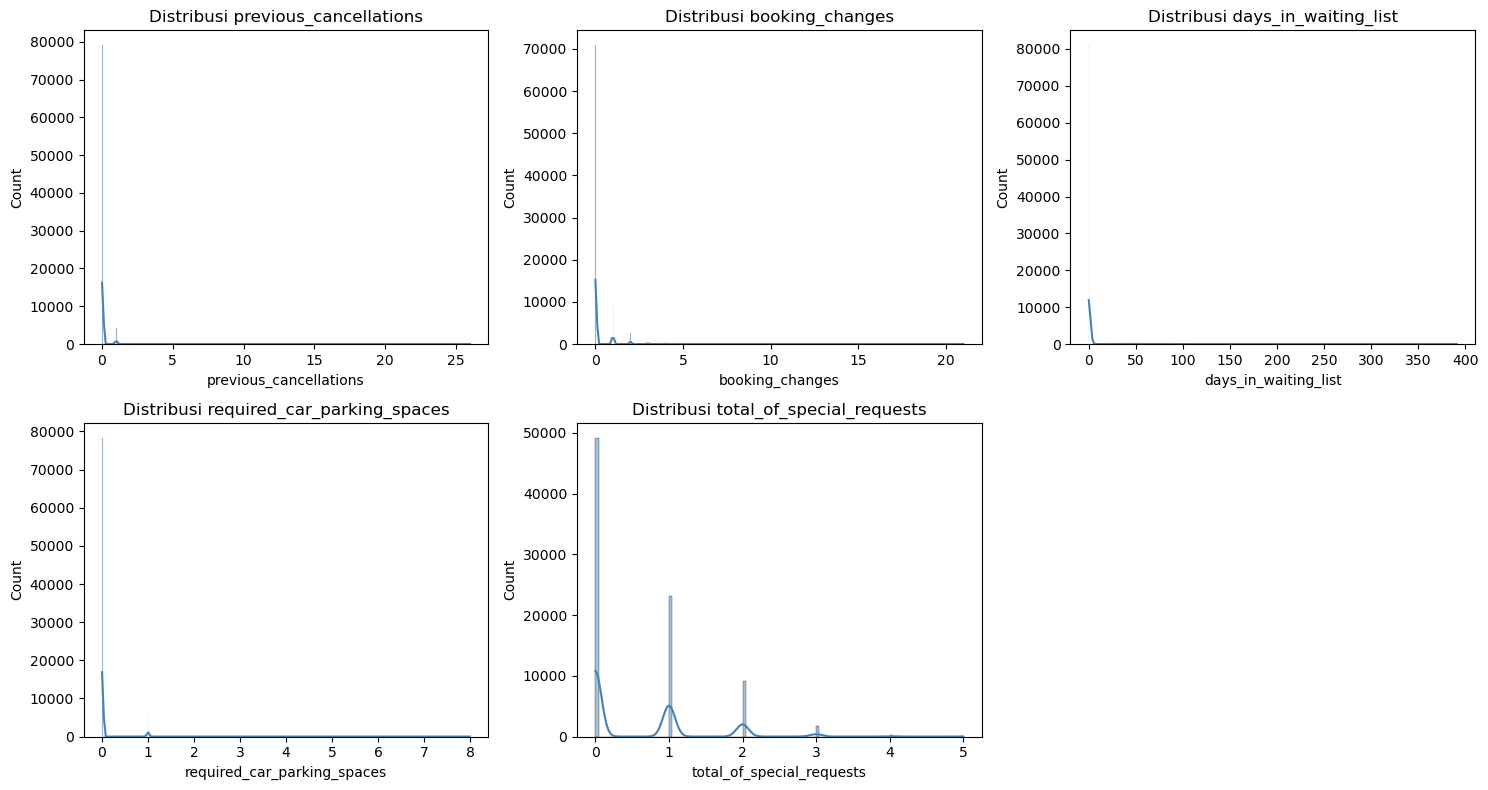

In [442]:
numerical_cols = ['previous_cancellations', 'booking_changes', 
                  'days_in_waiting_list', 'required_car_parking_spaces', 
                  'total_of_special_requests']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel(col)

axes[-1].axis('off')  # Matikan subplot kosong
plt.tight_layout()
plt.show()

Histogram + KDE memperlihatkan sebagian besar fitur numerik memiliki pola right-skewed (condong ke kanan) dan zero-inflated (nilai 0 sangat dominan).
Ringkasan pola per fitur:

* previous_cancellations

Mayoritas bernilai 0 (kebanyakan tamu belum pernah cancel).
Ada sedikit observasi dengan nilai tinggi (outlier), menunjukkan sebagian kecil tamu punya riwayat pembatalan berulang.

* booking_changes

Dominan 0, artinya banyak booking tidak mengalami perubahan.
Terdapat ekor panjang (beberapa booking mengalami banyak perubahan), mengindikasikan adanya segmen tamu yang lebih “dinamis”/tidak pasti.

* days_in_waiting_list

Hampir seluruhnya 0, berarti mayoritas booking langsung terkonfirmasi tanpa menunggu.
Ada outlier cukup besar (hari menunggu tinggi), meski jumlahnya kecil.

* required_car_parking_spaces

Sangat dominan 0 (sebagian besar tamu tidak meminta parkir).
Nilai >0 relatif jarang, sehingga fitur ini cenderung bersifat sinyal “khusus” untuk subset kecil tamu.

* total_of_special_requests

Nilai tersebar di rentang kecil (0–5).
Umumnya terkonsentrasi pada nilai rendah (0–2), namun tetap lebih “informatif” karena tidak ekstrem seperti fitur lain yang hampir semua 0.

Kondisi ini punya beberapa konsekuensi penting untuk preprocessing dan pemilihan model:

* Scaling & Outlier Handling: Karena terdapat outlier (mis. days_in_waiting_list, previous_cancellations), metode scaling yang robust lebih aman.
Penggunaan RobustScaler tepat karena memakai median dan IQR sehingga tidak “ketarik” oleh nilai ekstrem.
Scaling terutama penting untuk model sensitif skala seperti KNN dan Logistic Regression (model tree-based relatif tidak terlalu terpengaruh).

* Zero-Inflation: Sinyal “Ada vs Tidak Ada”: Fitur seperti previous_cancellations, booking_changes, days_in_waiting_list, dan required_car_parking_spaces didominasi nilai 0.
Dalam kasus seperti ini, sinyal utama sering kali adalah apakah nilainya 0 atau > 0, bukan besarnya nilai.
Potensi feature engineering: membuat flag biner seperti:

has_prev_cancellation = (previous_cancellations > 0)
was_in_waiting_list = (days_in_waiting_list > 0)
needs_parking = (required_car_parking_spaces > 0)

* Pola Non-Linear & Interaksi: Outlier dan kombinasi kondisi (mis. banyak perubahan booking + tidak ada deposit) cenderung membentuk hubungan non-linear terhadap target.
Model tree/ensemble (Bagging, RandomForest, Gradient Boosting, XGBoost) umumnya lebih kuat menangkap pola ini dibanding model linear.

* Keterkaitan dengan Objective (F2): Karena tujuan bisnis adalah meminimalkan False Negative (booking cancel tapi tidak terdeteksi), maka evaluasi tidak cukup dengan akurasi.
Metrik seperti F2-score relevan, dan optimasi threshold membantu menggeser trade-off sesuai biaya bisnis.

#### c. Distribusi Variabel Kategorik

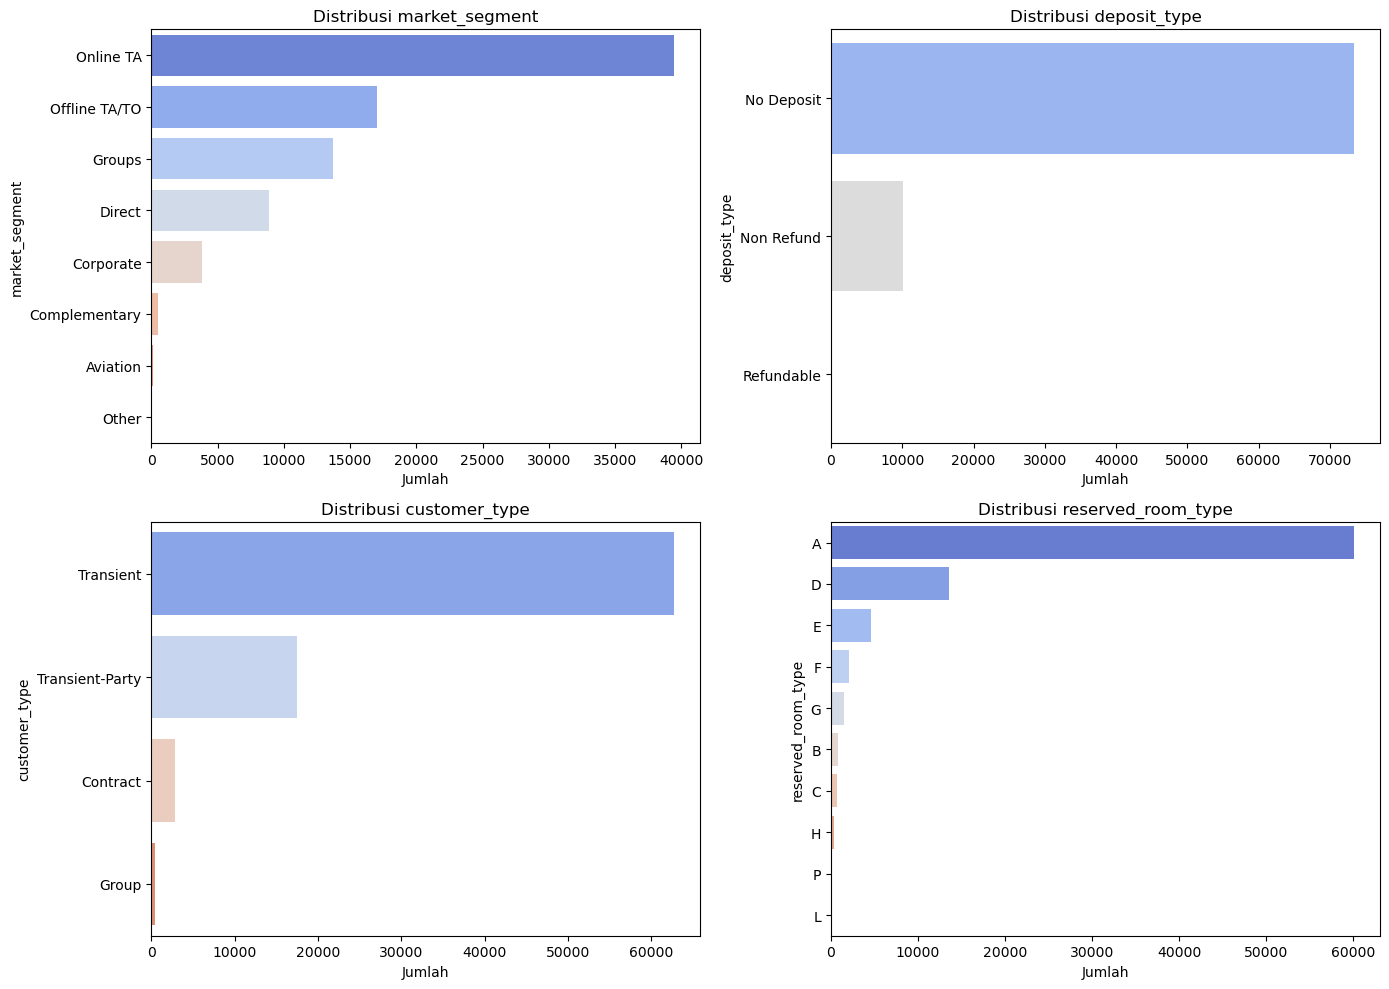

In [443]:
categorical_cols = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, ax=axes[i], order=order, palette='coolwarm')
    axes[i].set_title(f'Distribusi {col}')
    axes[i].set_xlabel('Jumlah')

plt.tight_layout()
plt.show()

Countplot untuk fitur kategorik menunjukkan adanya kategori yang sangat dominan (tidak merata), yang penting untuk interpretasi bisnis dan encoding.

* market_segment

Didominasi oleh Online TA, diikuti Offline TA/TO, lalu Groups dan Direct.
Ini mengindikasikan hotel sangat bergantung pada channel OTA yang umumnya memiliki fleksibilitas pembatalan lebih tinggi.

* deposit_type

Sangat didominasi oleh No Deposit.
Non Refund jauh lebih sedikit, dan Refundable sangat kecil.
Artinya mayoritas booking memiliki komitmen finansial rendah sejak awal.

* customer_type

Mayoritas adalah Transient, disusul Transient-Party.
Contract dan Group relatif kecil.
Ini sesuai dengan profil city hotel/transient: volume tinggi dengan durasi inap pendek.

* reserved_room_type

Ada tipe kamar yang sangat dominan (terutama A), sementara tipe lain jauh lebih sedikit.
Ini menunjukkan komposisi inventori/permintaan tidak merata antar tipe kamar.

Visualisasi countplot menunjukkan distribusi kategori yang tidak merata (ada kategori dominan) serta adanya fitur dengan jumlah kategori berbeda-beda. Ini mempengaruhi encoding, risiko overfitting, dan performa generalisasi.

* Encoding untuk Low Cardinality (kategori sedikit)

Fitur seperti market_segment, deposit_type, customer_type, dan reserved_room_type cocok menggunakan One-Hot Encoding.
handle_unknown='ignore' penting untuk mencegah error saat ada kategori baru pada data inference/produksi.

* High Cardinality Feature: country memiliki banyak nilai unik (kardinalitas tinggi). Jika di-OneHot, dimensi fitur bisa meledak dan meningkatkan risiko overfitting.
Penggunaan Binary Encoding (atau alternatif seperti frequency/target encoding dengan CV) membantu menjaga dimensi tetap efisien.

* Kategori Dominan vs Minor: Dominasi kategori tertentu (mis. channel tertentu atau No Deposit) berpotensi membuat model “belajar shortcut” yang terlalu bergantung pada kelas mayoritas.
Praktik mitigasi:

validasi dengan Stratified split/CV,
evaluasi menggunakan metrik yang selaras bisnis (Recall/F2),
inspeksi confusion matrix untuk memastikan FN tetap rendah.

* Rare Categories (kategori sangat jarang)

Kategori yang sangat sedikit sampelnya bisa menjadi:sinyal kuat tapi rawan overfitting, atau noise.
Pertimbangan: menggabungkan kategori sangat jarang menjadi label “Other” untuk meningkatkan stabilitas model.

* Interaksi antar fitur kategorik (penting untuk risiko cancel)

Kombinasi kategori sering lebih informatif daripada masing-masing kategori sendiri (contoh: Online TA + No Deposit).
Model tree/ensemble lebih natural menangkap interaksi ini tanpa harus membuat aturan manual.

## 2. Bivariate Analysis (Hubungan Fitur vs Target)

#### a. Kategorik vs Target (Cancellation Rate per Kategori)

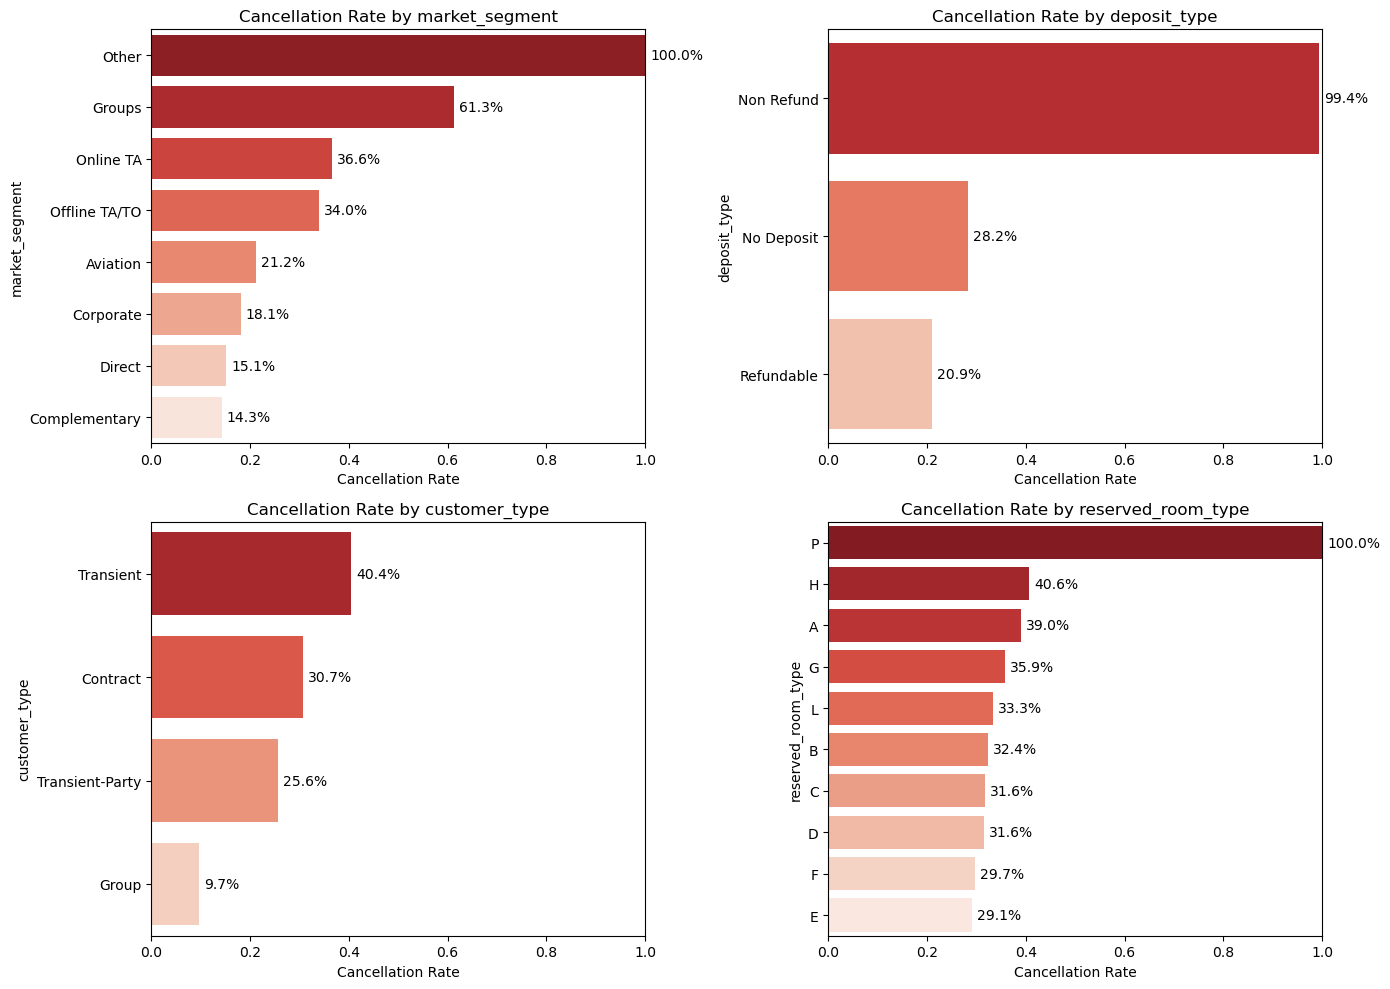

In [444]:
categorical_cols = ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # Hitung cancellation rate per kategori
    cancel_rate = df.groupby(col)['is_canceled'].mean().sort_values(ascending=False)
    
    sns.barplot(x=cancel_rate.values, y=cancel_rate.index, ax=axes[i], palette='Reds_r')
    axes[i].set_title(f'Cancellation Rate by {col}')
    axes[i].set_xlabel('Cancellation Rate')
    axes[i].set_xlim(0, 1)
    
    # Tambahkan label persentase
    for j, v in enumerate(cancel_rate.values):
        axes[i].text(v + 0.01, j, f'{v:.1%}', va='center')

plt.tight_layout()
plt.show()

Analisis Faktor Risiko Pembatalan (Cancellation Drivers)

Grafik ini menunjukkan proporsi pembatalan (Cancellation Rate) berdasarkan empat atribut utama tamu. Semakin panjang bar (warna merah tua), semakin tinggi risiko pembatalan di segmen tersebut.

1. Market Segment: Risiko Tinggi pada Grup & OTA

Grafik Kiri Atas

* Observation: Segmen 'Groups' memiliki tingkat pembatalan sangat tinggi (~61.3%), diikuti oleh 'Online TA' (Travel Agents) sebesar ~36.6%. Sebaliknya, tamu yang memesan secara 'Direct' (langsung ke hotel) memiliki tingkat pembatalan yang rendah (~15%).
* Business Insight:

Tamu yang memesan langsung (Direct) cenderung lebih loyal dan berkomitmen.

Hotel harus lebih waspada terhadap pemesanan Groups dan Online TA karena volatilitasnya tinggi. Strategi overbooking mungkin lebih aman diterapkan pada segmen ini.

2. Deposit Type: Anomali "Non Refund"

Grafik Kanan Atas

* Observation: Terdapat temuan yang sangat kontradiktif (counter-intuitive). Tipe deposit 'Non Refund' justru memiliki tingkat pembatalan hampir 100% (99.4%), jauh lebih tinggi dibanding 'No Deposit' (28.2%).
* Business Insight:

Dalam dataset ini, label 'Non Refund' adalah indikator pembatalan terkuat. Kemungkinan besar, kebijakan deposit 'Non Refund' diterapkan secara khusus pada segmen tamu berisiko tinggi (seperti Grup tertentu) yang pada akhirnya tetap melakukan pembatalan meskipun hangus deposit, atau ada karakteristik data historis di mana deposit ini dikaitkan dengan pembatalan sistematis.
Action: Fitur ini akan menjadi variabel prediktor (feature importance) paling dominan dalam model Machine Learning.

3. Customer Type: Tamu Transit Lebih Labil

Grafik Kiri Bawah

* Observation: Tipe tamu 'Transient' (tamu individu jangka pendek) memiliki risiko pembatalan tertinggi (~40.4%), dibandingkan tipe 'Contract' atau 'Group' (pelanggan tipe grup terorganisir, bukan segmen pasar).
* Business Insight:

Tamu individu (Transient) seringkali memiliki rencana perjalanan yang fleksibel dan mudah berubah, sehingga menyumbang angka pembatalan terbesar.

Tamu dengan kontrak (Contract) lebih stabil karena terikat perjanjian kerja sama.

4. Reserved Room Type: Preferensi Kamar Mempengaruhi Risiko

Grafik Kanan Bawah

* Observation: Tipe kamar tertentu menunjukkan pola ekstrem. Tipe kamar 'P' memiliki tingkat pembatalan 100% (kemungkinan jumlah datanya sedikit), diikuti oleh tipe 'H' dan 'A'.
* Business Insight:

Ini mengindikasikan bahwa ketidakpuasan atau ketidakcocokan pada tipe kamar tertentu (atau mungkin tipe kamar mewah yang dipesan untuk acara khusus yang batal) berkontribusi pada keputusan pembatalan.

#### b. Numerik vs Target (Boxplot/Violinplot)

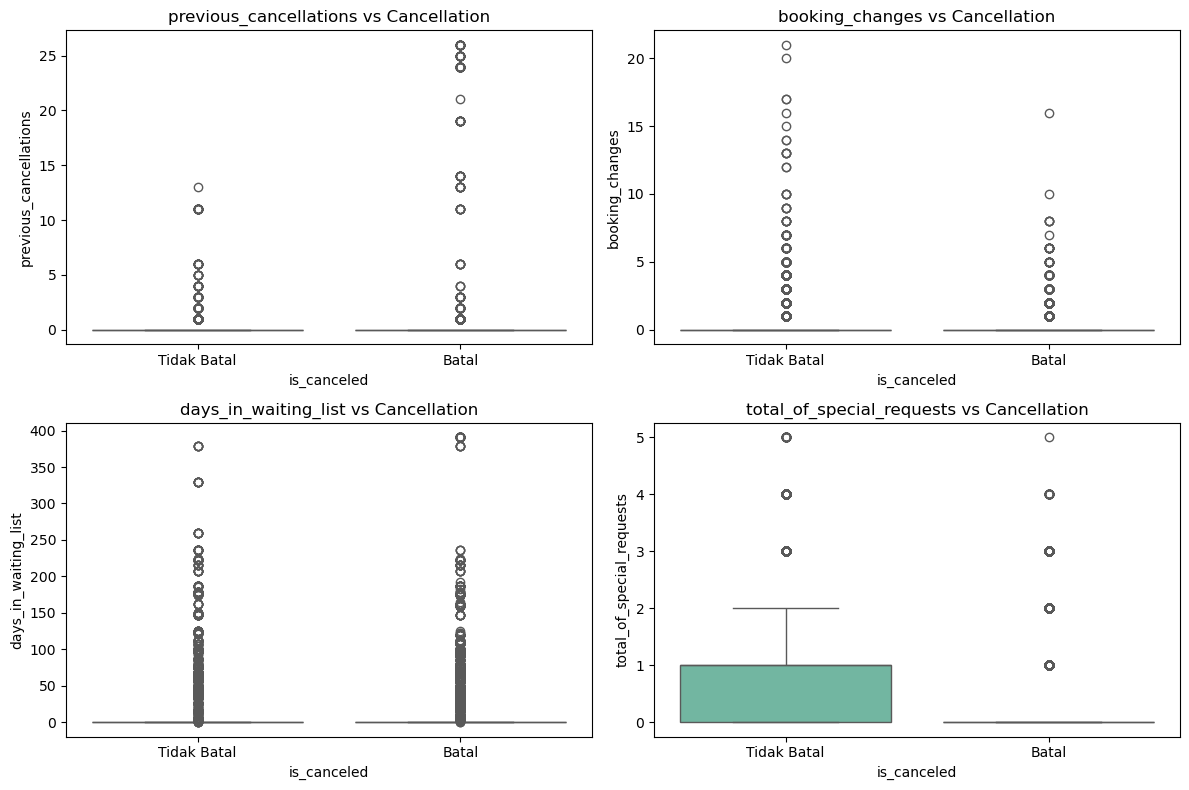

In [445]:
numerical_cols = ['previous_cancellations', 'booking_changes', 
                  'days_in_waiting_list', 'total_of_special_requests']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='is_canceled', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} vs Cancellation')
    axes[i].set_xticklabels(['Tidak Batal', 'Batal'])

plt.tight_layout()
plt.show()

Boxplot/Violinplot menunjukkan distribusi fitur numerik yang dibagi berdasarkan status pembatalan (Tidak Batal vs. Batal). Ini membantu melihat bagaimana nilai-nilai fitur berbeda antara booking yang dibatalkan dan yang tidak.

* previous_cancellations:

Mayoritas booking yang Tidak Batal (0) memiliki previous_cancellations bernilai 0.
Sebaliknya, booking yang Batal (1) menunjukkan adanya riwayat pembatalan sebelumnya yang lebih tinggi (nilai > 0), dengan sebaran yang lebih luas.
Implikasi: Fitur ini adalah prediktor yang sangat kuat. Riwayat pembatalan sebelumnya adalah sinyal risiko tinggi yang jelas.

* booking_changes:

Booking yang Batal (1) cenderung memiliki median dan sebaran jumlah perubahan yang lebih tinggi dibandingkan booking yang Tidak Batal (0).
Implikasi: Semakin banyak perubahan pada booking, semakin tinggi ketidakpastiannya dan probabilitas untuk dibatalkan.

* days_in_waiting_list:

Booking yang Batal (1) menunjukkan nilai days_in_waiting_list yang secara signifikan lebih tinggi (median dan nilai maksimum) dibandingkan booking yang Tidak Batal (0).
Implikasi: Booking yang masuk waiting list dalam waktu yang lebih lama memiliki kecenderungan lebih tinggi untuk dibatalkan.

* total_of_special_requests:

Secara mengejutkan, booking yang Tidak Batal (0) cenderung memiliki jumlah total_of_special_requests yang lebih banyak (median lebih tinggi) dibandingkan booking yang Batal (1).
Implikasi: Fitur ini berkorelasi terbalik; semakin banyak permintaan khusus dari tamu, semakin tinggi komitmennya dan semakin kecil kemungkinan pembatalan. Ini mendukung gagasan commitment_score yang akan dibangun.

## 3. Multivariate Analysis (Korelasi Antar Fitur)

#### a. Correlation Heatmap (Fitur Numerik)

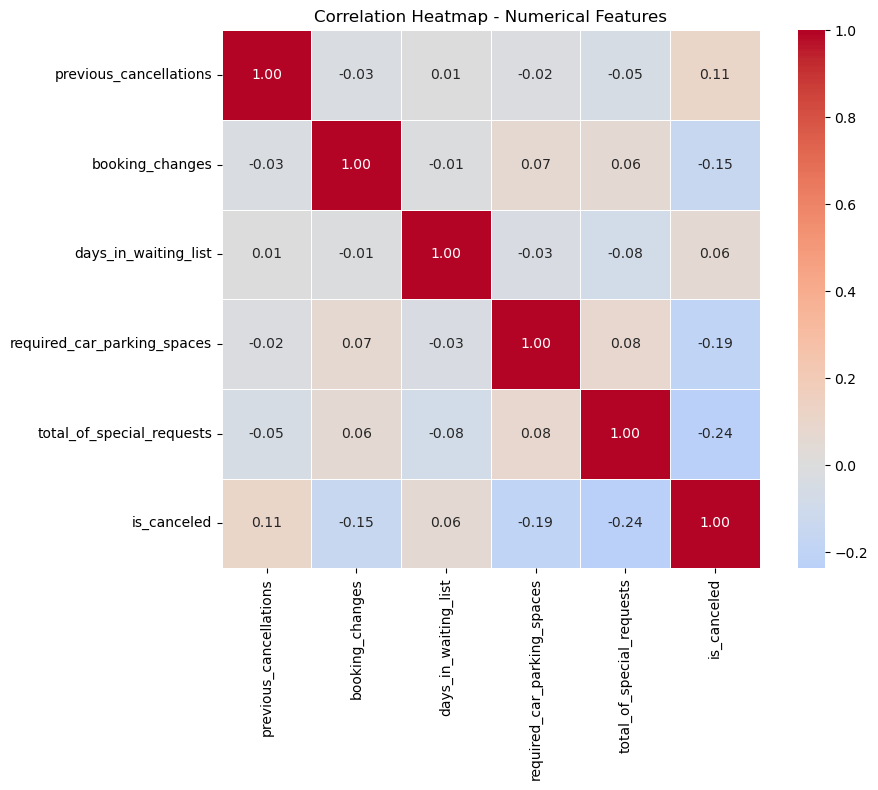

In [446]:
plt.figure(figsize=(10, 8))

numerical_df = df[['previous_cancellations', 'booking_changes', 
                   'days_in_waiting_list', 'required_car_parking_spaces', 
                   'total_of_special_requests', 'is_canceled']]

corr_matrix = numerical_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Heatmap - Numerical Features')
plt.tight_layout()
plt.show()

Heatmap korelasi memperlihatkan hubungan linear antar fitur numerik dan target is_canceled. Secara umum, korelasi antar fitur numerik relatif rendah, sehingga risiko multikolinearitas kuat tidak terlihat (fitur-fitur cenderung membawa informasi yang berbeda).
Korelasi terhadap target (is_canceled):

* total_of_special_requests memiliki korelasi negatif paling kuat dengan target (sekitar -0.24)
→ semakin banyak permintaan khusus, kecenderungan cancel makin kecil (indikasi “komitmen/engagement” tamu).
* required_car_parking_spaces korelasi negatif (sekitar -0.19)
→ permintaan parkir bisa menjadi sinyal niat menginap yang lebih serius.
* booking_changes korelasi negatif (sekitar -0.15)
→ pada data ini, booking yang mengalami perubahan cenderung sedikit lebih “bertahan” (lebih jarang cancel), walau relasinya tidak kuat.
* previous_cancellations korelasi positif (sekitar +0.11)
→ riwayat cancel meningkatkan risiko cancel berikutnya.
* days_in_waiting_list korelasi positif lemah (sekitar +0.06)
→ pernah waiting list sedikit berkaitan dengan peningkatan cancel, namun efeknya kecil.

Catatan interpretasi:

* Nilai korelasi yang kecil–sedang mengindikasikan bahwa sinyal cancel kemungkinan berasal dari kombinasi fitur (interaksi), bukan satu fitur numerik saja.

## Pertimbangan Feature Engineering Berdasarkan Analisis Korelasi

Berdasarkan heatmap korelasi dan juga korelasi fitur yang cenderung saling berkorelasi, dilakukan pembuatan fitur baru untuk meningkatkan performa model:

### 1. `commitment_score` (Skor Komitmen Tamu)
**Rasional:** Fitur `total_of_special_requests` memiliki korelasi negatif tertinggi dengan target (-0.23), 
menunjukkan bahwa tamu yang lebih "engaged" cenderung tidak membatalkan. 
Fitur ini menggabungkan beberapa sinyal komitmen menjadi satu skor.

### 2. `is_repeat_canceler` (Flag Pembatal Berulang)
**Rasional:** Fitur `previous_cancellations` memiliki korelasi positif (+0.11) dengan target. 
Transformasi ke binary memperjelas sinyal: pernah cancel = risiko lebih tinggi.

### 3. `booking_stability` (Stabilitas Booking)
**Rasional:** Fitur `booking_changes` (-0.14) dan `days_in_waiting_list` (+0.054) sama-sama 
mengukur "ketidakpastian" booking. Digabung menjadi satu metrik stabilitas.

### 4. `has_special_needs` (Flag Kebutuhan Khusus)
**Rasional:** Fitur `required_car_parking_spaces` memiliki korelasi sangat lemah (-0.02) dengan target.
Daripada dibuang, digabung dengan `total_of_special_requests` menjadi flag binary 
untuk menangkap sinyal "keseriusan" tamu.

### 5. `is_high_risk` (Flag Risiko Tinggi)
**Rasional:** Kombinasi dari beberapa kondisi berisiko tinggi berdasarkan logika bisnis,
yaitu tamu yang pernah cancel, tidak bayar deposit, dan tidak punya permintaan khusus.

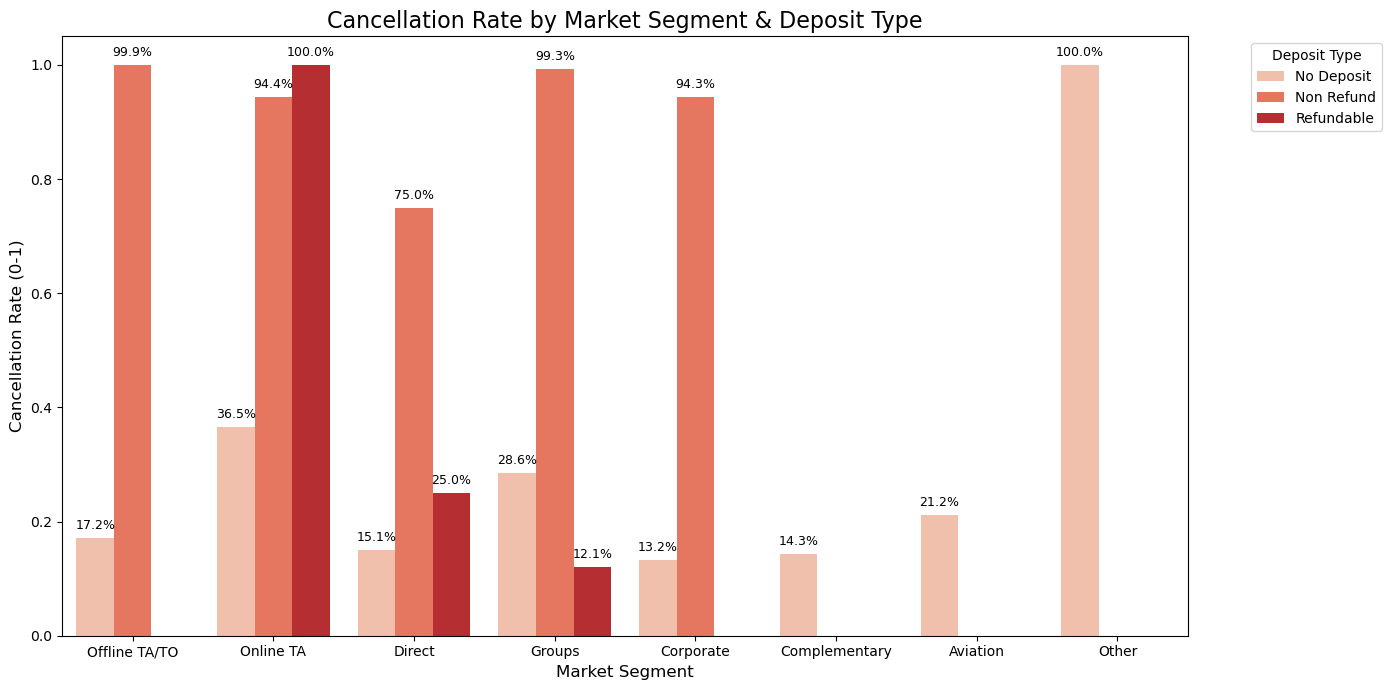

In [544]:
plt.figure(figsize=(14, 7))

# Membuat Grouped Bar Chart
# ci=None untuk menghilangkan garis error bar agar tampilan lebih bersih
ax = sns.barplot(
    data=df, 
    x='market_segment', 
    y='is_canceled', 
    hue='deposit_type', 
    ci=None, 
    palette='Reds' 
)

# Menambahkan judul dan label
plt.title('Cancellation Rate by Market Segment & Deposit Type', fontsize=16)
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Cancellation Rate (0-1)', fontsize=12)
plt.legend(title='Deposit Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Menampilkan persentase di atas setiap bar (Opsional, agar lebih informatif untuk PPT)
for p in ax.patches:
    if p.get_height() > 0: # Hanya label jika ada barnya
        ax.annotate(format(p.get_height(), '.1%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

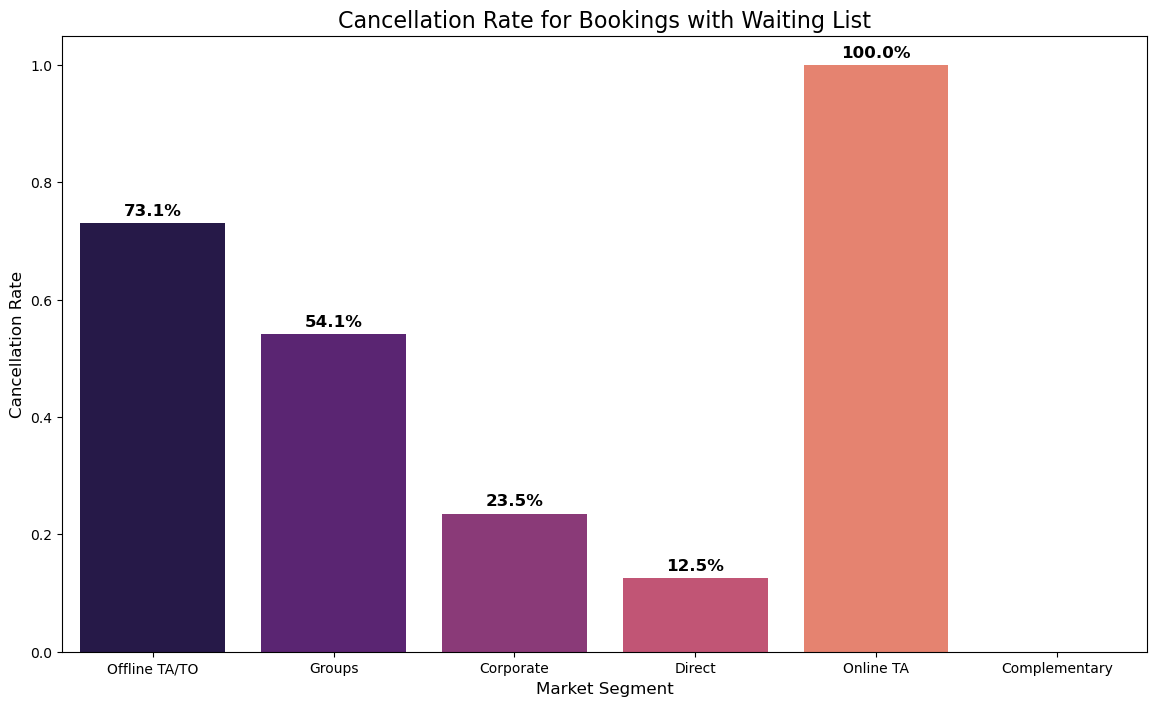

In [550]:
plt.figure(figsize=(14, 8))

# Filter data: hanya tamu yang masuk waiting list
waitlist_data = df[df['days_in_waiting_list'] > 0] 

sns.barplot(
    data=waitlist_data,
    x='market_segment', 
    y='is_canceled', # Ubah target ke is_canceled (0 atau 1)
    # hue='is_canceled', # Hapus hue karena kita menghitung rate dari is_canceled itu sendiri
    palette='magma',
    ci=None, 
    estimator=np.mean # Mean dari 0 dan 1 akan menghasilkan Rate (0.x)
)

plt.title('Cancellation Rate for Bookings with Waiting List', fontsize=16)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xlabel('Market Segment', fontsize=12)

# Menampilkan Persentase di atas batang
ax = plt.gca()
for p in ax.patches:
    if p.get_height() > 0:
        # Mengubah format angka menjadi persen (.1%) -> 0.6 jadi 60.0%
        ax.annotate(f'{p.get_height():.1%}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=12, fontweight='bold')

plt.show()

Grafik ini mengevaluasi risiko pembatalan spesifik pada tamu yang sempat masuk ke dalam daftar tunggu (Waiting List). Data ini menjawab pertanyaan: "Apakah tamu yang bersedia menunggu benar-benar jadi menginap, atau justru pergi?"
1. Online TA menunjukkan risiko pembatalan ekstrem (100%)

* Temuan Data: Segmen Online TA menunjukkan tingkat pembatalan 100% bagi mereka yang masuk waiting list.

Business Insight:

* Karakteristik pengguna Online Travel Agent (seperti Booking.com/Expedia) menginginkan kepastian instan.
* Jika kamar tidak tersedia saat itu juga (instant confirmation), mereka tidak akan menunggu. Mereka akan segera mencari hotel alternatif.
* Rekomendasi: Jangan menerapkan fitur waiting list untuk channel Online TA. Lebih baik tutup ketersediaan (Stop Sell) daripada memberikan harapan palsu yang merusak rasio konversi.

2. Offline TA/TO & Groups: Risiko Tinggi (54% - 73%)
* Temuan Data:

Offline TA/TO: Tingkat pembatalan sangat tinggi mencapai 73.1%.
Groups: Tingkat pembatalan sebesar 54.1%.

* Business Insight:

Travel Agent konvensional sering melakukan speculative booking (memesan banyak kamar untuk jaga-jaga) dan menaruhnya dalam daftar tunggu. Saat kuota klien mereka tidak terpenuhi, mereka membatalkan massal.
Ini adalah "Operational Waste". Hotel menahan inventaris untuk waiting list yang kemungkinan besar (lebih dari separuh) akan batal.
Rekomendasi: Minta deposit yang lebih besar atau non-refundable bagi Travel Agent yang ingin menaruh tamu di waiting list.

3. Direct & Corporate: Loyalitas & Komitmen Tinggi
* Temuan Data:

Tamu Direct (Pesan Langsung) hanya memiliki tingkat pembatalan 12.5%.
Tamu Corporate memiliki tingkat pembatalan 23.5%.

* Business Insight:

Angka pembatalan yang rendah ini menunjukkan Intent (Niat) yang Kuat. Jika seorang tamu rela menelepon atau datang ke hotel langsung untuk booking dan bersedia menunggu, berarti mereka memiliki preferensi kuat untuk menunggu dalam waiting list dalam mendapatkan kamar hotel yang nantinya tamu akan tempati (mungkin karena lokasi, brand, atau membership).
Rekomendasi: Prioritaskan alokasi kamar kosong (jika ada pembatalan lain) kepada segmen Direct dan Corporate terlebih dahulu, karena kemungkinan mereka jadi menginap ("conversion rate") jauh lebih tinggi dibanding segmen lain.

### b. Cancellation Rate: Deposit Type vs Market Segment (Cross Analysis)

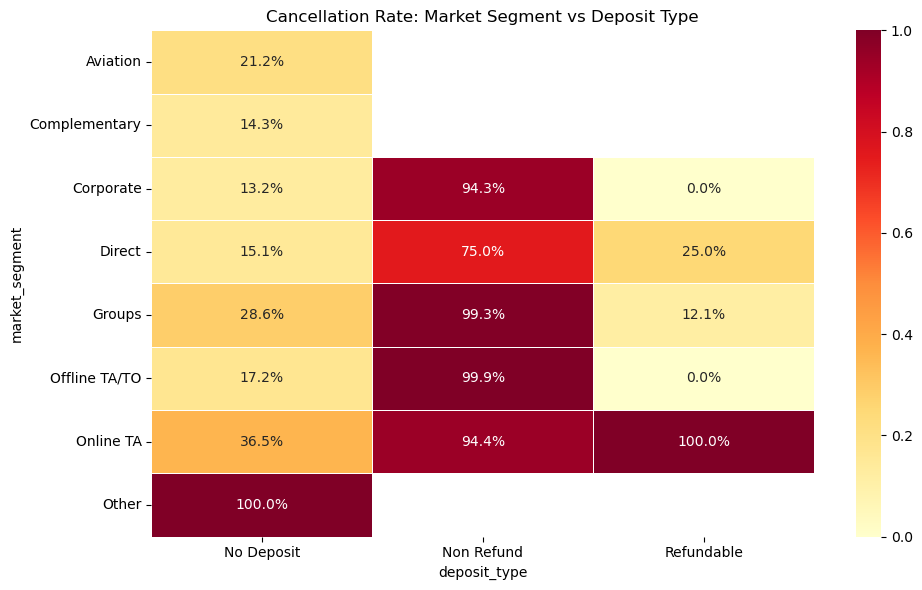

In [447]:
# Pivot table: cancellation rate
pivot = df.pivot_table(
    values='is_canceled', 
    index='market_segment', 
    columns='deposit_type', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='YlOrRd', fmt='.1%', linewidths=0.5)
plt.title('Cancellation Rate: Market Segment vs Deposit Type')
plt.tight_layout()
plt.show()

Heatmap ini menampilkan cancellation rate (proporsi is_canceled=1) untuk kombinasi kategori market_segment dan deposit_type. Tujuannya adalah melihat interaksi antar dua fitur kategorik yang tidak terlihat jika dianalisis terpisah.
Insight utama yang terlihat dari pola heatmap:

* Pada No Deposit, tingkat cancel bervariasi cukup jelas antar segmen:

Online TA cenderung lebih tinggi dibanding banyak segmen lain (sekitar 36%).
Groups juga relatif tinggi (sekitar 29%).
Segmen seperti Corporate/Direct/Complementary cenderung lebih rendah (sekitar belasan persen).


* Pada Non Refund, banyak kombinasi segmen menunjukkan cancellation rate yang sangat tinggi (mendekati 100% pada beberapa segmen).
* Pada Refundable, terdapat kombinasi yang ekstrem (misalnya ada sel dengan rate sangat tinggi).

### 4. Insight dari Top Countries

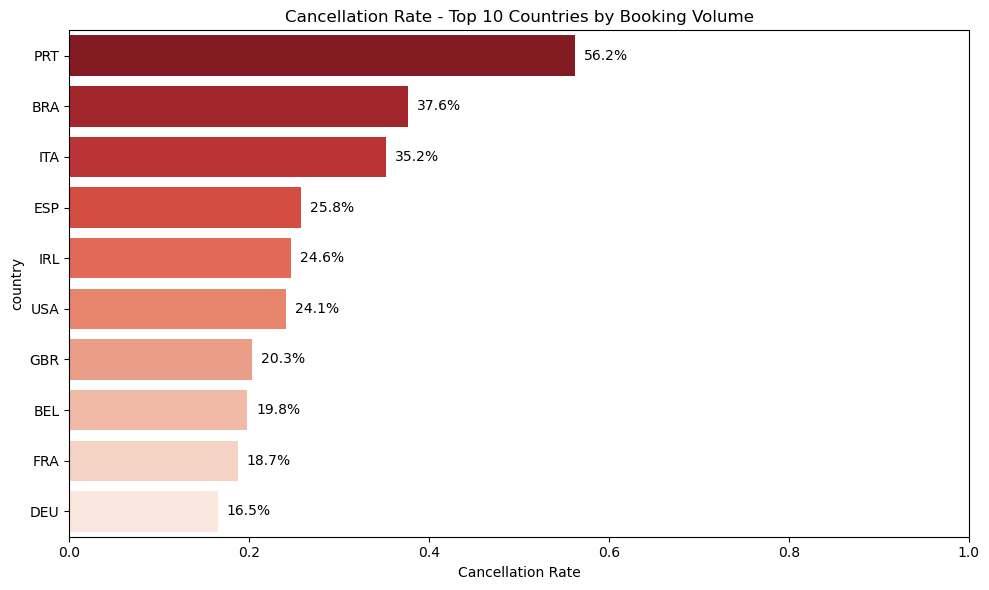

In [448]:
# Top 10 negara dengan booking terbanyak
top_countries = df['country'].value_counts().head(10).index

df_top = df[df['country'].isin(top_countries)]

# Cancellation rate per negara
cancel_by_country = df_top.groupby('country')['is_canceled'].agg(['sum', 'count', 'mean'])
cancel_by_country.columns = ['Total Cancel', 'Total Booking', 'Cancel Rate']
cancel_by_country = cancel_by_country.sort_values('Cancel Rate', ascending=False)

# Visualisasi
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=cancel_by_country['Cancel Rate'], y=cancel_by_country.index, palette='Reds_r')
plt.title('Cancellation Rate - Top 10 Countries by Booking Volume')
plt.xlabel('Cancellation Rate')
plt.xlim(0, 1)

for i, v in enumerate(cancel_by_country['Cancel Rate']):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center')

plt.tight_layout()
plt.show()

Visualisasi ini menampilkan cancellation rate untuk 10 negara dengan volume booking tertinggi. Terlihat bahwa tingkat pembatalan bervariasi cukup signifikan antar negara, artinya variabel country berpotensi membawa sinyal perilaku yang berbeda (misalnya perbedaan channel pemesanan, tujuan perjalanan, atau kebiasaan membatalkan).
Insight utama:

* PRT (Portugal) menjadi negara dengan booking terbanyak dan juga menunjukkan cancellation rate paling tinggi di antara top 10 (sekitar 56.2%). Ini mengindikasikan risiko cancel yang tinggi pada pasar domestik (atau bisa juga efek dari komposisi channel/segmen yang dominan untuk PRT).
* Negara dengan cancellation rate relatif tinggi berikutnya adalah:

BRA (sekitar 37.6%)
ITA (sekitar 35.2%)


* Beberapa negara berada pada tingkat menengah:

ESP (sekitar 25.8%)
IRL (sekitar 24.6%)
USA (sekitar 24.1%)


* Negara dengan cancellation rate relatif lebih rendah pada top 10:

GBR (sekitar 20.3%)
BEL (sekitar 19.8%)
FRA (sekitar 18.7%)
DEU (sekitar 16.5%)



Interpretasi & catatan penting:

* Karena grafik ini hanya memakai Top 10 negara berdasarkan volume, maka perbandingan antar negara cukup relevan secara bisnis (lebih stabil dibanding negara yang jumlah booking-nya sangat kecil).
* Perbedaan cancellation rate antar negara tidak selalu berarti “karena negaranya”, tetapi bisa menjadi proksi dari faktor lain seperti:

dominasi channel tertentu (mis. OTA vs Direct),
tipe pelanggan (Transient/Group),
kebijakan deposit atau kebiasaan perjalanan.

Catatan Tambahan dari Data Numerik:

* Mayoritas total booking yang dilakukan adalah untuk tamu yang tidak meminta ruang parkir (required_car_parking_spaces = 0), mencakup lebih dari 93.7% dari seluruh booking. Ini menguatkan bahwa permintaan parkir adalah sinyal perilaku yang sangat niche (jarang terjadi) tetapi mungkin indikasi komitmen tinggi jika diminta.

In [449]:
print(df['required_car_parking_spaces'].value_counts(normalize=True))

required_car_parking_spaces
0    0.937456
1    0.062245
2    0.000263
8    0.000024
3    0.000012
Name: proportion, dtype: float64


Output proporsi required_car_parking_spaces menunjukkan bahwa hampir seluruh tamu tidak meminta tempat parkir (nilai 0 mendominasi), sementara nilai 1 atau lebih jumlahnya sangat kecil. Pola seperti ini mengindikasikan fitur yang sangat tidak seimbang (highly skewed).
Implikasi terhadap model:

* Karena mayoritas nilainya 0, fitur ini cenderung memiliki sinyal prediktif yang lemah terhadap target is_canceled jika digunakan apa adanya (model “jarang” melihat variasi).
* Nilai > 0 memang bisa jadi indikator tipe tamu tertentu (misalnya tamu yang datang dengan kendaraan pribadi), tetapi karena populasinya kecil, efeknya pada performa model sering tidak signifikan atau rentan noise.

Keputusan Feature Engineering
Berdasarkan bagian “Pertimbangan Feature Engineering Berdasarkan Analisis Korelasi” sebelumnya, feature engineering difokuskan pada fitur-fitur yang:

1. terlihat memiliki hubungan/arah yang jelas terhadap is_canceled (secara korelasi atau perbedaan pola pada plot), dan
2. secara bisnis masuk akal sebagai indikator risiko pembatalan (misal perilaku booking, channel, deposit, lead time).

Karena itu, saya tidak membuat fitur has_special_needs.

adapun alasan saya tidak memakai fitur has_special_needs:

* Pada dataset ini, “special needs” bukan kolom yang robust dan definisinya sering ambigu (bisa tertukar dengan special requests biasa), sehingga berpotensi menambah noise.
* Dari hasil analisis korelasi/EDA sebelumnya, sinyal yang lebih konsisten justru datang dari fitur-fitur lain (misalnya deposit_type, market_segment, riwayat pembatalan, dan/atau indikator risiko yang diturunkan dari kombinasi fitur).
* Prinsip saya berfokus pada: lebih baik sedikit fitur tetapi kuat dan stabil, daripada menambah fitur yang interpretasinya lemah dan berisiko memperburuk generalisasi.

# FEATURE ENGINEERING PIPELINE

Pada tahap ini, disini saya menciptakan fitur-fitur baru (new features) dari kolom yang sudah ada untuk membantu model menangkap pola perilaku tamu dengan lebih baik. Strategi yang digunakan meliputi penanganan fitur zero-inflated, pembuatan skor komitmen, serta interaksi antar variabel penting.

a. Handling Zero-Inflated Features (Binary Flags)

Banyak fitur numerik dalam dataset ini bersifat Zero-Inflated, artinya mayoritas datanya bernilai 0 (contoh: sebagian besar tamu tidak pernah cancel sebelumnya). Variasi nilai kecil (misal: 1 vs 2 kali cancel) seringkali kurang signifikan dibandingkan perbedaan antara 0 (Tidak Pernah) dan >0 (Pernah). Oleh karena itu, saya membuat binary flags:

* is_repeat_canceler: Penanda apakah tamu pernah membatalkan pesanan sebelumnya. Diambil dari kolom previous_cancellations. (1 = Pernah, 0 = Belum).
* has_booking_changes: Penanda apakah tamu pernah melakukan perubahan pada booking (ganti kamar/tanggal). Perubahan ini seringkali menjadi sinyal bahwa tamu tersebut aktif/serius (engaged).
* was_in_waiting_list: Penanda apakah tamu pernah masuk daftar tunggu.

b. Derived & Interaction Features (Fitur Turunan)

Berdasarkan analisis korelasi dan logika bisnis, saya membuat fitur komposit untuk menangkap risiko dan komitmen:

* commitment_score (Skor Komitmen):

Merupakan gabungan dari total_of_special_requests dan required_car_parking_spaces.
Rasional: Tamu yang merepotkan diri untuk meminta lahan parkir atau menyampaikan permintaan khusus (seperti extra bed atau quiet room) menunjukkan niat menginap yang lebih kuat (high commitment) dibandingkan tamu yang memesan tanpa detail apapun.

* booking_stability (Stabilitas Booking):

Menggabungkan sinyal positif dari booking_changes (tamu aktif mengurus pesanan) dan sinyal negatif dari days_in_waiting_list (ketidakpastian ketersediaan kamar).
Logika: Jika tamu melakukan perubahan, booking dianggap lebih stabil (+1). Jika tamu masuk waiting list, booking dianggap kurang stabil (-1).

* is_high_risk (Indikator Risiko Tinggi):

Mengidentifikasi profil tamu yang secara historis memiliki cancellation rate ekstrem.
Kriteria: Tamu yang mengambil tipe deposit 'Non Refund' (biasanya promo murah) tetapi bukan dari segmen korporat, ATAU tamu yang merupakan is_repeat_canceler.

c. Cardinality Reduction

* country_group:

Kolom country memiliki ratusan negara unik (high cardinality). saya juga menyederhanakannya menjadi tiga kelompok:

PRT (Portugal): Pasar domestik dominan dengan karakteristik risiko unik.
Top International: Negara-negara penyumbang turis terbesar (GBR, FRA, ESP, DEU, dll).
Other: Negara lainnya.

### A. Tentukan Fitur (Feature Selection sederhana berdasarkan tipe data)
- Kita memisahkan kolom berdasarkan cara penanganannya

In [450]:
# Definisikan X dan y dari data df
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

# Split Data (80% Train, 20% Test)
# Stratify=y penting agar proporsi Cancel di train & test seimbang
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [451]:
def feature_engineering(df_input):
    # Buat copy agar data asli tidak terganggu
    df = df_input.copy()
    
    # --- 1. is_repeat_canceler (Flag Pembatal Berulang) ---
    # (Dibuat di awal karena dipakai untuk hitung is_high_risk)
    df['is_repeat_canceler'] = (df['previous_cancellations'] > 0).astype(int)
    
    # --- 2. is_high_risk (Flag Risiko Tinggi - Updated) ---
    # Definisi: Non Refund TAPI bukan Corporate (terjebak promo) ATAU Repeat Canceler
    condition_non_refund = (df['deposit_type'] == 'Non Refund') & (df['market_segment'] != 'Corporate')
    condition_repeat_cancel = (df['is_repeat_canceler'] == 1)
    
    df['is_high_risk'] = (condition_non_refund | condition_repeat_cancel).astype(int)
    
    # --- 3. Country Grouping (Mengatasi High Cardinality) ---
    # Logika: PRT (sendiri), Top International (gabung), Sisanya 'Other'
    top_international = ['GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'USA']
    
    conditions = [
        df['country'] == 'PRT',                  # Grup 1: Portugal
        df['country'].isin(top_international)    # Grup 2: Top Internasional
    ]
    choices = ['PRT', 'Top_International']
    
    df['country_group'] = np.select(conditions, choices, default='Other')

    # --- 4. commitment_score (Skor Komitmen) ---
    df['commitment_score'] = (
        df['total_of_special_requests'] + 
        df['required_car_parking_spaces'] + 
        df['booking_changes']
    )
    
    # --- 5. booking_stability (Stabilitas Booking) ---
    df['booking_stability'] = df['booking_changes'] - (df['days_in_waiting_list'] * 0.1)
    
    return df

# Terapkan ke data
X_train_eng = feature_engineering(X_train)
X_test_eng = feature_engineering(X_test)

In [452]:
# 1. Kelompokkan Kolom Berdasarkan Tipe Datanya
# Kita pilih fitur-fitur TERBAIK (termasuk hasil engineering tadi)

# a. Fitur Kategorikal (Untuk OneHotEncoding)
cat_features = [
    'market_segment',
    'deposit_type',
    'customer_type',
    'country_group',     
    'reserved_room_type'
]

cat_features

['market_segment',
 'deposit_type',
 'customer_type',
 'country_group',
 'reserved_room_type']

In [453]:
# b. Fitur Numerikal (Untuk Scaling)
# Kita pakai RobustScaler karena 'commitment_score' atau 'booking_stability' mungkin punya outlier
num_features = [
    'commitment_score', 
    'booking_stability', 
    'previous_cancellations', 
    'booking_changes', 
    'days_in_waiting_list'
]

num_features

['commitment_score',
 'booking_stability',
 'previous_cancellations',
 'booking_changes',
 'days_in_waiting_list']

In [454]:
# c. Fitur Biner (Passthrough / Lewat saja)
# Fitur ini sudah 0 dan 1, tidak perlu diapa-apakan.
bin_features = [
    'is_repeat_canceler',
    'is_high_risk'
]

bin_features

['is_repeat_canceler', 'is_high_risk']

In [455]:
# 2. Buat Pipeline Kecil untuk Tiap Tipe
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

cat_pipe

Pipeline(steps=[('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [456]:
# Pipeline Numerikal: RobustScaler (tahan outlier)
num_pipe = Pipeline([
    ('scaler', RobustScaler())
])

num_pipe

Pipeline(steps=[('scaler', RobustScaler())])

In [457]:
# 3. Gabungkan dalam ColumnTransformer (Preprocessor Utama)
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_features),
    ('num', num_pipe, num_features),
    ('bin', 'passthrough', bin_features) # Fitur biner langsung dilewatkan
], remainder='drop') # Kolom lain yang tidak disebut (misal kolom raw) akan dibuang

preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'country_group',
                                  'reserved_room_type']),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['commitment_score', 'booking_stability',
                                  'previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list']),
                                ('bin', 'passthrough',
                                 ['is_repeat_canceler', 'is_high_risk'])])

In [458]:
preprocessor.fit_transform(X_train_eng, y_train)

,cat__market_segment_Aviation,cat__market_segment_Complementary,cat__market_segment_Corporate,cat__market_segment_Direct,cat__market_segment_Groups,cat__market_segment_Offline TA/TO,cat__market_segment_Online TA,cat__market_segment_Other,cat__deposit_type_No Deposit,cat__deposit_type_Non Refund,cat__deposit_type_Refundable,cat__customer_type_Contract,cat__customer_type_Group,cat__customer_type_Transient,cat__customer_type_Transient-Party,cat__country_group_Other,cat__country_group_PRT,cat__country_group_Top_International,cat__reserved_room_type_A,cat__reserved_room_type_B,cat__reserved_room_type_C,cat__reserved_room_type_D,cat__reserved_room_type_E,cat__reserved_room_type_F,cat__reserved_room_type_G,cat__reserved_room_type_H,cat__reserved_room_type_L,cat__reserved_room_type_P,num__commitment_score,num__booking_stability,num__previous_cancellations,num__booking_changes,num__days_in_waiting_list,bin__is_repeat_canceler,bin__is_high_risk
80442,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0
69764,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0
83427,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0
7073,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0,0
80474,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60977,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,1
72170,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,1
72328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7341,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0


In [459]:
# Masukkan data mentah ke fungsi feature_engineering
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [460]:
y.value_counts(normalize=True)

is_canceled
0    0.631723
1    0.368277
Name: proportion, dtype: float64

## Model Selection & Algorithms Definition

### Pada tahap ini, kita akan menguji berbagai algoritma Machine Learning. Berikut adalah pembedahan mendalam mengenai logika, contoh penerapan/cara kerja, serta analisis keunggulan maupun kekurangan dari masing-masing model:

#### 1. Logistic Regression
Deskripsi:
Meskipun mengandung kata "Regression", algoritma ini digunakan untuk klasifikasi. Logistic Regression bekerja dengan menghitung jumlah bobot dari input fitur, lalu memetakan hasilnya ke dalam kurva berbentuk "S" (Sigmoid Function) yang memiliki rentang nilai antara 0 hingga 1. Nilai ini merepresentasikan probabilitas. Jika probabilitas > 0.5, data diklasifikasikan sebagai Kelas 1 (Ya), dan sebaliknya Kelas 0 (Tidak). Ini adalah model statistik standar untuk menaksir risiko.
Contoh Kasus:

 Perbankan: Menentukan apakah nasabah layak diberikan kartu kredit atau tidak. Model menghitung skor probabilitas berdasarkan gaji, usia, dan hutang. Jika skor > batas tertentu, kredit disetujui.

 Kelebihan: Sangat cepat, outputnya berupa probabilitas (bukan sekadar label), dan mudah dijelaskan kepada tim bisnis (interpretability tinggi).

 Kekurangan: Tidak mampu menangkap hubungan yang rumit (non-linear). Jika datanya kompleks, akurasinya seringkali rendah.

<img src="https://zd-brightspot.s3.us-east-1.amazonaws.com/wp-content/uploads/2022/04/11040521/46-4-e1715636469361.png">

* Referensi: Scikit-Learn - Logistic Regression

#### 2. K-Nearest Neighbors (KNN)
Deskripsi:
KNN bekerja dengan prinsip "Siapa tetanggamu, itulah kamu". Algoritma ini tidak membuat model matematika saat training (disebut lazy learner). Saat ada data baru yang ingin diprediksi, algoritma ini akan menghitung jarak (biasanya Euclidean distance) ke seluruh data latih, mengambil sejumlah 'K' tetangga terdekat, dan melakukan voting. Jika mayoritas tetangga adalah "Batal", maka data baru tersebut diprediksi "Batal".
Contoh Kasus:

 Rekomendasi Produk: E-commerce menyarankan barang kepada Anda berdasarkan apa yang dibeli oleh orang-orang yang profil belanjanya "jaraknya dekat" (mirip) dengan Anda.

 Kelebihan: Sangat sederhana dan efektif untuk data yang polanya mengelompok secara lokal.

 Kekurangan: Menjadi sangat lambat jika datanya jutaan baris (karena harus hitung jarak satu per satu), dan performanya anjlok jika skala angkanya tidak disamakan (scaling).

<img src="https://stataiml.com/images/knn/knn_algorithm.png">

* Referensi: Scikit-Learn - KNN

#### 3. Decision Tree
Deskripsi:
Decision Tree memecah data dengan mengajukan serangkaian pertanyaan "Ya/Tidak" secara bertingkat, menyerupai diagram alir (flowchart). Dimulai dari "Akar" (fitur paling penting), data dipecah terus menerus hingga mencapai "Daun" (keputusan akhir). Algoritma ini mencari titik pemecahan terbaik yang membuat data di setiap cabangnya menjadi se-homogen mungkin (menggunakan kriteria Gini Impurity atau Entropy).
Contoh Kasus:

 Diagnosa Medis: Dokter mendiagnosa penyakit dengan urutan pertanyaan: "Apakah demam? (Ya/Tidak)" -> "Apakah batuk? (Ya/Tidak)" -> "Apakah sesak? (Ya/Tidak)" -> Diagnosa: Flu Biasa vs Infeksi Paru.

 Kelebihan: Mudah dipahami logikanya oleh orang awam, tidak butuh normalisasi data.

 Kekurangan: Sangat sensitif. Perubahan sedikit saja pada data bisa mengubah total struktur pohonnya. Cenderung overfitting (terlalu rumit) jika tidak dibatasi.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250514105137773224/Decision-Tree-.webp">

* Referensi: Scikit-Learn - Decision Tree

#### 4. Bagging Classifier

Deskripsi:
Bagging (Bootstrap Aggregating) menerapkan konsep "Wisdom of Crowds". Daripada mengandalkan satu Decision Tree yang mungkin tidak stabil, Bagging membuat banyak pohon sekaligus. Setiap pohon dilatih menggunakan sampel data acak yang berbeda (teknik bootstrap). Keputusan akhirnya diambil berdasarkan suara terbanyak (majority voting) dari seluruh pohon tersebut.
Contoh Kasus:

 Survey Politik: Daripada bertanya pada satu ahli (yang mungkin bias), lembaga survei bertanya pada ribuan sampel acak masyarakat untuk mendapatkan prediksi hasil pemilu yang lebih akurat dan stabil.

 Kelebihan: Mengurangi varians (ketidakstabilan) dari model tunggal, sehingga hasil lebih konsisten.

 Kekurangan: Lebih berat dijalankan komputer dibanding satu model, dan kita kehilangan visualisasi pohon tunggal yang mudah dijelaskan.

<img src="https://media.licdn.com/dms/image/v2/D5612AQFNuVROwlbA0g/article-cover_image-shrink_600_2000/article-cover_image-shrink_600_2000/0/1715981791085?e=2147483647&v=beta&t=XdgIuX-pc_vy7vvlnxUT_AFifIfuvNbBd-soU4UF1Ms">

* Referensi: Scikit-Learn - Bagging



#### 5. Random Forest
Deskripsi:
Random Forest adalah "Hutan" yang berisi banyak Decision Tree. Ini adalah pengembangan canggih dari Bagging. Bedanya: Jika Bagging hanya mengacak data, Random Forest juga mengacak fitur. Di setiap percabangan pohon, algoritma hanya boleh memilih fitur terbaik dari sebagian kecil fitur yang tersedia secara acak. Ini memaksa pohon-pohon untuk menjadi "berbeda" satu sama lain, sehingga saat digabungkan, error mereka saling meniadakan.
Contoh Kasus:

 Deteksi Fraud: Bank menganalisis jutaan transaksi. Satu pohon mungkin jago mendeteksi fraud dari lokasi, pohon lain jago dari nominal. Gabungan ribuan pohon ini menciptakan sistem keamanan yang sangat tangguh.

 Kelebihan: Akurasi sangat tinggi, jarang overfitting, dan bisa menangani ribuan fitur input tanpa masalah.

 Kekurangan: Model "Black Box" (sulit dilacak alur logikanya), waktu training cukup lama karena membangun ratusan pohon.

<img src="https://images.prismic.io/turing/65980c06531ac2845a27269b_Random_Forest_Algorithm_400798756c.webp?auto=format,compress">

* Referensi: Scikit-Learn - Random Forest



#### 6. AdaBoost (Adaptive Boosting)
Deskripsi:
AdaBoost (Adaptive Boosting) bekerja secara estafet. Algoritma membuat model pertama (biasanya pohon yang sangat pendek/sederhana), lalu melihat data mana yang salah diprediksi. Model kedua kemudian dibuat khusus untuk memprediksi data-data yang "sulit" tersebut dengan benar. Proses ini berulang, di mana model berikutnya selalu fokus memperbaiki kesalahan model sebelumnya.
Contoh Kasus:

 Face Detection: Kamera HP mendeteksi wajah. Filter pertama mendeteksi warna kulit, filter kedua (yang belajar dari kesalahan filter 1) mendeteksi bentuk mata, dst. Gabungannya menjadi pendeteksi wajah akurat.

 Kelebihan: Sangat ampuh mengubah model yang "bodoh" (weak learner) menjadi model cerdas.

 Kekurangan: Sangat sensitif terhadap noise (data sampah/outlier), karena algoritma akan memaksakan diri untuk memperbaiki error pada data sampah tersebut.

<img src="https://softscients.com/wp-content/uploads/2020/03/1.-AdaBoost-for-Machine-Learning.jpg">

* Referensi: Scikit-Learn - AdaBoost



#### 7. Gradient Boosting
Deskripsi:
Gradient Boosting adalah teknik boosting yang menggunakan pendekatan matematika kalkulus (Gradient Descent). Bayangkan bermain golf: Pukulan pertama mendekati lubang, pukulan kedua membidik sisa jarak (error/residual) dari pukulan pertama, pukulan ketiga membidik sisa jarak dari pukulan kedua, dan seterusnya. Model baru ditambahkan untuk meminimalisir sisa error dari gabungan model sebelumnya secara bertahap.
Contoh Kasus:

 Estimasi Harga Rumah (Zillow/Traveloka): Model awal menebak harga rata-rata. Model kedua mengoreksi harga berdasarkan lokasi. Model ketiga mengoreksi lagi berdasarkan luas tanah. Hasil akhirnya sangat presisi.

 Kelebihan: Sering menjadi juara dalam kompetisi data tabular karena akurasinya yang luar biasa.

 Kekurangan: Butuh penyetelan parameter (hyperparameter tuning) yang cermat, dan training berjalan sekuensial (tidak bisa paralel) sehingga lama.

<img src="https://miro.medium.com/v2/1*NLI9QFoWDltdXJf3_rwbbw.png">

* Referensi: Scikit-Learn - Gradient Boosting



#### 8. XGBoost (Extreme Gradient Boosting)
Deskripsi:
XGBoost adalah versi "Supercharged" dari Gradient Boosting. Algoritma ini didesain ulang dari nol untuk efisiensi komputasi maksimal. XGBoost memiliki fitur pruning (pemangkasan pohon) otomatis, penanganan missing value bawaan, dan regularisasi (pencegah overfitting) yang terintegrasi. Ini adalah standar emas industri saat ini untuk data terstruktur.
Contoh Kasus:

 Prediksi Churn Pelanggan Telko: Perusahaan telekomunikasi menggunakan XGBoost untuk memprediksi pelanggan mana yang akan pindah operator bulan depan dengan akurasi tinggi, memproses jutaan data pelanggan dalam waktu singkat.

 Kelebihan: Eksekusi jauh lebih cepat dari boosting biasa, performa prediksi sangat tinggi, dan fleksibel.

 Kekurangan: Kompleksitas tinggi dengan banyak parameter yang harus diatur.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250905153324093033/data_set.webp">

* Referensi: XGBoost Documentation

## **Model Selection with Cross Validation**

- Tujuannya untuk menentukan base model terbaik

In [461]:
# define algo
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

# bagging
bagging = BaggingClassifier(random_state=0)

# random forest
rf = RandomForestClassifier(random_state=0)

#gradient boosting
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost = XGBClassifier(random_state=0)

list_model = [logreg, knn, tree, bagging, 
              rf, adaboost, gboost, xgboost]

In [462]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [463]:
# Cross Validation
cv_all = []
cv_mean = []
cv_std = []

for model in list_model:

    pipe_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    cv_score = cross_val_score(
        estimator = pipe_model,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring = f2_scorer
    )

    cv_all.append(cv_score.round(4))
    cv_mean.append(cv_score.mean())
    cv_std.append(cv_score.std())

In [464]:
df_cv = pd.DataFrame()
df_cv["model"] = list_model
df_cv["f2_all"] = cv_all
df_cv["f2_mean"] = cv_mean
df_cv["f2_std"] = cv_std

df_cv.sort_values(["f2_mean", "f2_std"], 
                  ascending=[False, True])

,model,f2_all,f2_mean,f2_std
3,BaggingClassifier(random_state=0),"[0.7038, 0.7121, 0.7084, 0.7097, 0.72]",0.710801,0.005314
7,"XGBClassifier(base_score=None, booster=None, c...","[0.7163, 0.7063, 0.7043, 0.7054, 0.7174]",0.709926,0.005689
4,RandomForestClassifier(random_state=0),"[0.7038, 0.711, 0.69, 0.7094, 0.7201]",0.706851,0.009928
2,DecisionTreeClassifier(random_state=0),"[0.7032, 0.7095, 0.6894, 0.7084, 0.7201]",0.706116,0.010007
6,GradientBoostingClassifier(random_state=0),"[0.681, 0.6822, 0.6759, 0.6786, 0.6866]",0.680872,0.003587
1,KNeighborsClassifier(),"[0.524, 0.6434, 0.6465, 0.644, 0.6466]",0.620916,0.048452
5,AdaBoostClassifier(random_state=0),"[0.6018, 0.601, 0.6055, 0.6043, 0.6156]",0.605633,0.005275
0,LogisticRegression(random_state=0),"[0.573, 0.5715, 0.5779, 0.5756, 0.5843]",0.576447,0.004503


#### Model Benchmarking Evaluation
Setelah melakukan Cross-Validation pada berbagai algoritma, saya mendapatkan hasil performa rata-rata berdasarkan metric F2-Score (yang memprioritaskan Recall atau kemampuan mendeteksi pembatalan) sebagai berikut:
Analisis Hasil:

Top Performer: Bagging Classifier menduduki peringkat pertama dengan skor rata-rata 70.92%. Model ini berhasil meningkatkan stabilitas dan akurasi dibandingkan base learner-nya (Decision Tree) yang berada di posisi ke-4 (69.83%).

Model Selection:
Berdasarkan hasil di atas, saya memutuskan untuk memilih Bagging Classifier sebagai model final untuk tahap selanjutnya.
Alasan Pemilihan:

* Skor Tertinggi: Secara empiris memberikan F2-Score rata-rata tertinggi.
* Stabilitas: Memiliki standar deviasi yang rendah (0.006), artinya performa model konsisten (stabil) walaupun diuji pada lipatan (fold) data yang berbeda-beda.
* Reduksi Varians: Bagging terbukti ampuh mengatasi masalah high variance (overfitting) yang sering dialami oleh Decision Tree tunggal.

maka dari itu, saya melakukan train dan test base model mennggunakan model baggingclassifier

In [465]:
# train dan test base model
pipe_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("modeling", BaggingClassifier(random_state=0))
])

pipe_base.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'country_group',
                                                   'reserved_room_type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['commitment_score',
                                                   'booking_stability',
                                                   'previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list']),
                                                 ('bin', 'passthrough',
                                                  ['is_repeat_canceler',
                                                   'is_high_risk'])])),
                ('modeling', BaggingClassifier(random_state=0))])

In [466]:
# hitung Train dan Test F2
y_train_base = pipe_base.predict(X_train)
y_test_base = pipe_base.predict(X_test)

train_f2 = fbeta_score(y_train, y_train_base, beta=2)
test_f2 = fbeta_score(y_test, y_test_base, beta=2)

print(f"Train f2: {train_f2:.1%}")
print(f"Test f2: {test_f2:.1%}")

Train f2: 72.0%
Test f2: 70.4%


## Feature Importance

Di sini, kita menggunakan teknik Feature Importance dari algoritma Random Forest. Algoritma ini akan menilai seberapa besar kontribusi setiap fitur dalam mengurangi impurity (ketidakmurnian) saat memisahkan kelas target (Cancel vs Not Cancel). Fitur dengan skor rendah akan dibuang.

In [467]:
X_encoded = preprocessor.fit_transform(X_train)

In [468]:
# Mendapatkan nama fitur setelah encoding (penting agar kita tahu nama kolomnya)
feature_names = preprocessor.get_feature_names_out()

In [469]:
# 2. Latih Model Random Forest Sederhana untuk Inspeksi
# Kita gunakan RF karena algoritma ini memiliki atribut 'feature_importances_' bawaan
rf_selector = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf_selector.fit(X_encoded, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [470]:
# 3. Buat DataFrame Importance
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_selector.feature_importances_
})

In [471]:
# Urutkan dari yang paling penting
feat_imp = feat_imp.sort_values(by='importance', ascending=False).reset_index(drop=True)

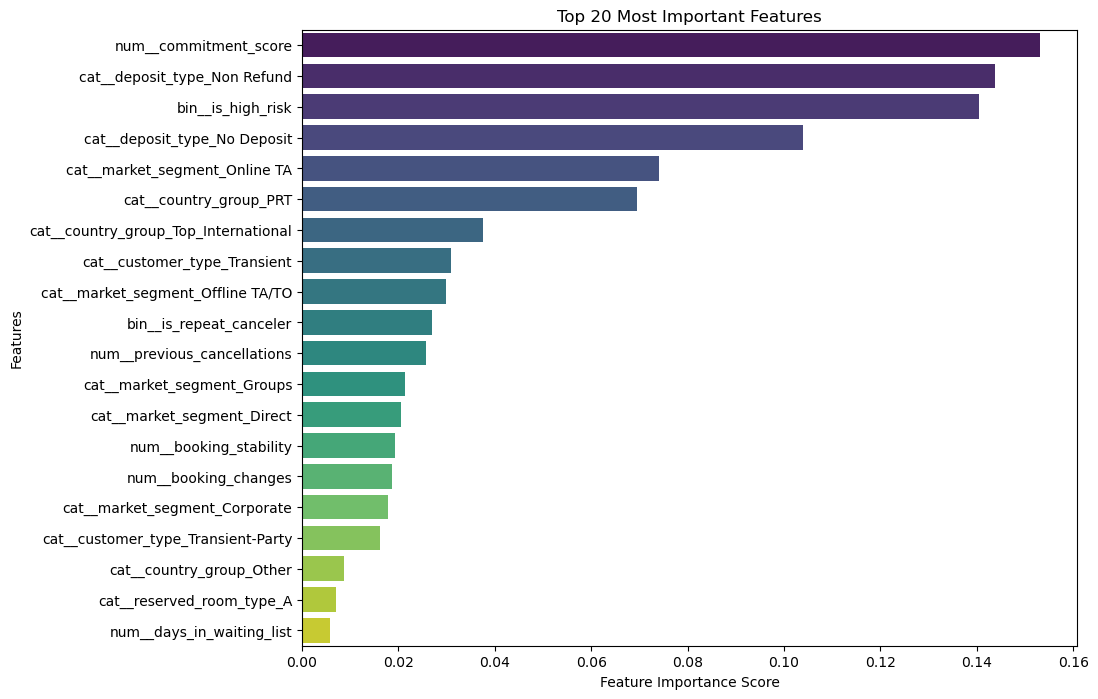

In [472]:
# 4. Visualisasi (Opsional tapi sangat berguna)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feat_imp.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

Hasil kode menunjukkan bahwa fitur-fitur hasil rekayasa (feature engineering) mendominasi peringkat teratas, membuktikan bahwa transformasi data yang dilakukan sebelumnya sangat efektif dalam menangkap pola perilaku tamu.

Berikut adalah interpretasi dari Top 20 Fitur yang dihasilkan:

1. Dominasi Fitur Turunan (Engineered Features)
Tiga dari empat fitur teratas adalah fitur baru yang dibuat secara manual, bukan kolom asli dari dataset mentah:

* num__commitment_score (Peringkat 1 - Score: 0.153): Skor ini menjadi prediktor paling kuat. Fitur ini menggabungkan permintaan khusus, parkir, dan perubahan booking. Tingginya skor ini menunjukkan bahwa "effort" atau interaksi tamu saat memesan sangat berkorelasi dengan jadi atau tidaknya mereka menginap.

* bin__is_high_risk (Peringkat 3 - Score: 0.140): Fitur ini memvalidasi asumsi bisnis bahwa tamu dengan deposit 'Non Refund' tetapi bukan dari segmen korporat (kemungkinan terjebak promo murah) atau tamu yang pernah batal sebelumnya, memiliki risiko cancel yang sangat distingtif.

2. Pengaruh Komitmen Finansial (deposit_type)

* cat__deposit_type_Non Refund (Peringkat 2 - Score: 0.144) dan cat__deposit_type_No Deposit (Peringkat 4 - Score: 0.104) menempati posisi ke-2 dan ke-4. Ini menegaskan bahwa jenis pembayaran deposit adalah indikator "hitam-putih" yang sangat jelas untuk menentukan apakah tamu akan datang atau batal.

3. Segmentasi & Lokasi

* cat__market_segment_Online TA (Peringkat 5 - Score: 0.074): Menunjukkan bahwa tamu dari Online Travel Agent memiliki pola pembatalan yang sangat spesifik (cenderung tinggi) dibandingkan segmen lain.

* cat__country_group_PRT (Peringkat 6 - Score: 0.069): Asal negara Portugal (Domestik) menjadi fitur lokasi paling penting, mengindikasikan adanya perbedaan perilaku yang signifikan antara tamu lokal dan internasional.

In [473]:
# 5. Tampilkan Tabel 10 Fitur Teratas
print("Top 10 Fitur Paling Berpengaruh:")
print(feat_imp.head(10))

Top 10 Fitur Paling Berpengaruh:
                                feature  importance
0                 num__commitment_score    0.153133
1          cat__deposit_type_Non Refund    0.143718
2                     bin__is_high_risk    0.140431
3          cat__deposit_type_No Deposit    0.103839
4         cat__market_segment_Online TA    0.074132
5                cat__country_group_PRT    0.069487
6  cat__country_group_Top_International    0.037504
7          cat__customer_type_Transient    0.030949
8     cat__market_segment_Offline TA/TO    0.029889
9               bin__is_repeat_canceler    0.027004


### Hyperparameter Tuning

Setelah menetapkan Bagging Classifier sebagai model terbaik pada tahap benchmarking, langkah selanjutnya adalah melakukan optimasi performa melalui Hyperparameter Tuning.

## Apa itu Hyperparameter Tuning?
Jika model diibaratkan sebagai sebuah radio, hyperparameter adalah tombol-tombol putar (knobs) yang mengatur frekuensinya. Pada tahap benchmarking sebelumnya, kita hanya menggunakan pengaturan standar (default). Sekarang, kita akan mencari kombinasi pengaturan terbaik agar model dapat bekerja lebih presisi dan menghasilkan skor F2 yang lebih tinggi.
Strategi Tuning (Bagging Classifier)

## Mengapa Menggunakan RandomizedSearchCV?
Dalam proyek ini, saya memilih menggunakan RandomizedSearchCV daripada GridSearchCV. Berikut adalah alasan teknis dan logis di balik keputusan tersebut:

1. Cara Kerja

* GridSearchCV (Pencarian Menyeluruh): Metode ini mencoba SEMUA kemungkinan kombinasi parameter yang kita definisikan. Jika kita punya 3 parameter dan masing-masing punya 5 opsi nilai, GridSearch akan melakukan training sebanyak 3×5=15 kombinasi dikali jumlah Fold CV.

* RandomizedSearchCV (Pencarian Acak): Metode ini tidak mencoba semua kombinasi. Ia hanya mengambil sejumlah sampel kombinasi secara acak (sebanyak n_iter yang kita tentukan).

2. Analisis Kelebihan & Kekurangan (Pros & Cons)

FiturKelebihan (Pros) Kekurangan (Cons) Efisiensi WaktuSangat Cepat. Karena tidak mencoba semua kombinasi, RandomizedSearch bisa selesai jauh lebih cepat, terutama jika search space (ruang pencarian) parameter sangat luas dan kompleks.Tidak Menjamin Hasil Terbaik Mutlak. Karena mengambil sampel secara acak, ada kemungkinan kecil kombinasi parameter yang "paling sempurna" terlewatkan.FleksibilitasMendukung Distribusi Kontinu. Kita bisa memasukkan range angka (misal: 10 sampai 100) dan membiarkan algoritma memilih angka acak di antaranya, tidak terpaku pada angka kaku seperti GridSearch [10, 20, 30].Hasil Bisa Bervariasi. Jika random_state tidak dikunci, hasil tuning bisa berubah setiap kali dijalankan (kurang deterministik dibanding Grid).EksplorasiLebih Luas. Dalam waktu komputasi yang sama, RandomizedSearch bisa mengeksplorasi variasi parameter yang lebih beragam dibandingkan GridSearch yang mungkin macet di satu area.Perlu Iterasi Cukup. Jika n_iter diset terlalu sedikit (misal cuma 5 kali), hasil tuning mungkin tidak optimal karena sampel terlalu sedikit.

3. Konteks pada Project Ini

Pada model Bagging Classifier, parameter yang dituning cukup berat secara komputasi (seperti n_estimators atau jumlah pohon).

* Jika menggunakan GridSearchCV dengan kombinasi parameter yang banyak, proses training bisa memakan waktu berjam-jam.
* Dengan RandomizedSearchCV (di-set n_iter=50), kita membatasi proses agar hanya mencoba 50 kombinasi terbaik secara acak. Ini memberikan keseimbangan (trade-off) yang sangat baik antara waktu training yang masuk akal dan peningkatan performa yang signifikan.


Karena kita menggunakan Bagging Classifier, ada beberapa parameter kunci yang akan kita eksplorasi:

1. n_estimators: Jumlah pohon keputusan yang akan dibangun. Semakin banyak pohon biasanya semakin stabil, tetapi waktu komputasi akan meningkat.
2. max_samples: Jumlah atau persentase sampel data yang digunakan untuk melatih setiap pohon. Ini mempengaruhi seberapa beragam (diverse) pohon-pohon di dalam ensemble.
3. max_features: Jumlah fitur yang diambil secara acak untuk melatih setiap pohon.
4. bootstrap: Menentukan apakah sampel data diambil dengan pengembalian (replacement) atau tidak.

## Metode Pencarian
Kita akan menggunakan RandomizedSearchCV untuk mencoba berbagai kombinasi parameter tersebut secara otomatis. Proses ini akan menggunakan teknik Cross Validation untuk memastikan parameter yang terpilih benar-benar bagus untuk data umum, bukan kebetulan saja.
Target optimasi kita tetap konsisten: memaksimalkan F2-Score (untuk memprioritaskan deteksi pembatalan).

In [474]:
param_space = {
    "modeling__n_estimators": [50, 100, 150, 200],      # 4 values
    "modeling__max_samples": [0.5, 0.7, 0.8, 1.0],      # 4 values
    "modeling__max_features": [0.5, 0.7, 0.8, 1.0],     # 4 values
    "modeling__bootstrap": [True],                       # 1 value (fix)
    "modeling__bootstrap_features": [True, False],       # 2 values
    # Ganti nested estimator params dengan estimator langsung
    "modeling__estimator": [
        DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=0),
        DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=0),
        DecisionTreeClassifier(max_depth=15, class_weight='balanced', random_state=0),
        DecisionTreeClassifier(max_depth=10, class_weight=None, random_state=0),
    ]
}

Kode di atas mendefinisikan "ruang pencarian" yang akan dieksplorasi oleh RandomizedSearchCV. Saya sedang menyetel model Bagging Classifier yang di dalamnya terdapat sekumpulan Decision Tree.

Tujuan utama konfigurasi ini adalah mencari keseimbangan terbaik antara Bias (model terlalu sederhana) dan Variance (model terlalu kompleks/overfitting).

1. Ensemble Parameters (Pengaturan "Hutan")

Parameter ini mengatur bagaimana cara kerja kelompok (ensemble) secara keseluruhan:

* modeling__n_estimators: [50, 100, 150, 200]

Ini menentukan jumlah pohon (voters) dalam komite.

Logika: Semakin banyak pohon (misal 200), prediksi biasanya lebih stabil dan akurat (mengurangi variance), namun waktu training akan lebih lama. Kita mencari angka yang cukup tinggi untuk stabil tapi tetap efisien.

* modeling__max_samples: [0.5, 0.7, 0.8, 1.0]

Menentukan berapa persen data yang "diintip" oleh setiap pohon.

Logika: Jika diset 0.5, setiap pohon hanya belajar dari 50% data secara acak. Ini memaksa setiap pohon menjadi unik dan tidak seragam, yang sangat penting untuk mencegah overfitting.

* modeling__max_features: [0.5, 0.7, 0.8, 1.0]

Sama seperti max_samples, tapi ini untuk fitur/kolom.
Logika: Memaksa pohon untuk tidak selalu mengandalkan fitur terkuat (seperti deposit_type), tapi juga belajar dari fitur lain. Ini membuat model lebih robust (tangguh).\

* modeling__bootstrap: [True]

Mengaktifkan teknik Bagging (Bootstrap Aggregating). Data diambil secara acak dengan pengembalian (replacement).

2. Base Estimator Parameters (Pengaturan "Pohon")

Bagian ini (modeling__estimator) sangat krusial. Kita tidak hanya mengatur jumlah pohonnya, tapi juga mengatur seberapa "pintar" atau "kompleks" setiap pohon individu di dalamnya.
Kita menguji 4 variasi Decision Tree:

* Variasi Kedalaman (max_depth: 5, 10, 15)

Depth 5 (Pendek): Pohon sederhana. Cepat, tapi berisiko Underfitting (kurang pintar).

Depth 15 (Dalam): Pohon kompleks. Bisa menangkap pola detail, tapi berisiko Overfitting (terlalu menghapal data latih).

Depth 10 (Sedang): Jalan tengah (Sweet Spot).

* Penanganan Imbalance (class_weight: 'balanced' vs None)

'balanced': Ini adalah strategi vital untuk dataset kita yang imbalanced (37% cancel). Opsi ini akan memberi "hukuman" lebih berat jika model salah memprediksi kelas minoritas (Cancel).

None: Sebagai pembanding (baseline), untuk melihat apakah pembobotan otomatis benar-benar diperlukan atau tidak.

Kesimpulan Strategi dalam param_space

Dengan kombinasi param_space ini, RandomizedSearchCV akan mencoba menjawab pertanyaan:

"Mana yang lebih baik untuk memprediksi pembatalan hotel ini? Apakah kita butuh ratusan pohon yang sederhana (Depth 5) tapi banyak, atau sedikit pohon yang kompleks (Depth 15)? Dan apakah fitur 'balanced weight' wajib dipakai?"

In [475]:
randomsearch = RandomizedSearchCV(
    estimator=pipe_base,
    param_distributions=param_space,
    n_iter=50,
    cv=3,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=0
)

randomsearch

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['market_segment',
                                                                                'deposit_type',
                                                                                'customer_type',
                                                                                'country_group',
                                                                                'reserved_room_type']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['commitment_score'...
                                                                                       random_state=0),
                                                                DecisionTreeClassifier(class_weight='balanced',
                                                                                       max_depth=15,
                                                                                       random_state=0),
                                                                DecisionTreeClassifier(max_depth=10,
                                                                                       random_state=0)],
                                        'modeling__max_features': [0.5, 0.7,
                                                                   0.8, 1.0],
                                        'modeling__max_samples': [0.5, 0.7, 0.8,
                                                                  1.0],
                                        'modeling__n_estimators': [50, 100, 150,
                                                                   200]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=2)

In [476]:
randomsearch.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['market_segment',
                                                                                'deposit_type',
                                                                                'customer_type',
                                                                                'country_group',
                                                                                'reserved_room_type']),
                                                                              ('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler())]),
                                                                               ['commitment_score'...
                                                                                       random_state=0),
                                                                DecisionTreeClassifier(class_weight='balanced',
                                                                                       max_depth=15,
                                                                                       random_state=0),
                                                                DecisionTreeClassifier(max_depth=10,
                                                                                       random_state=0)],
                                        'modeling__max_features': [0.5, 0.7,
                                                                   0.8, 1.0],
                                        'modeling__max_samples': [0.5, 0.7, 0.8,
                                                                  1.0],
                                        'modeling__n_estimators': [50, 100, 150,
                                                                   200]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
                   verbose=2)

In [477]:
randomsearch.best_params_

{'modeling__n_estimators': 150,
 'modeling__max_samples': 1.0,
 'modeling__max_features': 1.0,
 'modeling__estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=15, random_state=0),
 'modeling__bootstrap_features': False,
 'modeling__bootstrap': True}

In [478]:
randomsearch.best_score_

np.float64(0.7474444604726603)

In [479]:
df_tuning_results = pd.DataFrame(randomsearch.cv_results_)
df_tuning_results.nlargest(n=5, columns="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__n_estimators,param_modeling__max_samples,param_modeling__max_features,param_modeling__estimator,param_modeling__bootstrap_features,param_modeling__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,43.311289,3.421641,2.874048,0.073705,150,1.0,1.0,DecisionTreeClassifier(class_weight='balanced'...,False,True,"{'modeling__n_estimators': 150, 'modeling__max...",0.744457,0.748923,0.748954,0.747444,0.002113,1
31,11.141938,0.092513,1.095565,0.129653,50,0.8,1.0,DecisionTreeClassifier(class_weight='balanced'...,False,True,"{'modeling__n_estimators': 50, 'modeling__max_...",0.744730,0.749308,0.748226,0.747421,0.001954,2
27,27.845001,1.980427,2.631623,0.072705,150,0.5,1.0,DecisionTreeClassifier(class_weight='balanced'...,False,True,"{'modeling__n_estimators': 150, 'modeling__max...",0.743987,0.749168,0.747687,0.746948,0.002179,3
46,29.074337,0.339294,1.160894,0.078234,200,0.5,1.0,DecisionTreeClassifier(class_weight='balanced'...,False,True,"{'modeling__n_estimators': 200, 'modeling__max...",0.743791,0.749301,0.747398,0.746830,0.002285,4
14,48.410495,7.091814,3.646717,0.363698,200,0.7,1.0,DecisionTreeClassifier(class_weight='balanced'...,False,True,"{'modeling__n_estimators': 200, 'modeling__max...",0.742912,0.749271,0.747756,0.746646,0.002712,5


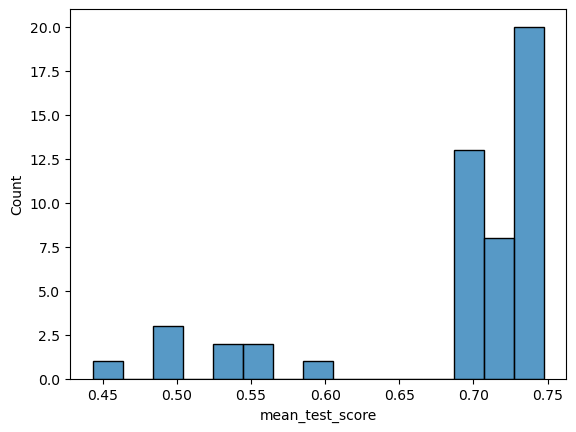

In [480]:
sns.histplot(data=df_tuning_results,
             x="mean_test_score")
plt.show()

Visualisasi histogram di atas menampilkan sebaran skor performa (Mean Test Score - F2 Score) dari 50 kombinasi hyperparameter yang diuji cobakan oleh RandomizedSearchCV.

Maksud dari nilai pada visualisasi data tersebut apa:

1. Dominasi Performa Tinggi (High Performance Cluster):

Terlihat jelas adanya pengelompokan (cluster) besar di sebelah kanan, yaitu pada rentang skor 0.70 hingga 0.75.
Bar tertinggi berada di ujung kanan, menunjukkan bahwa mayoritas kombinasi parameter yang dipilih secara acak berhasil menghasilkan model dengan performa yang sangat baik. Ini mengindikasikan bahwa model Bagging Classifier dengan base estimator Decision Tree cukup robust (stabil); ia cenderung menghasilkan skor tinggi asalkan parameternya berada di area yang wajar.


2. Model Sub-optimal (Low Performance Cluster):

Terdapat segelintir model (jumlah kecil) yang terpisah jauh di sebelah kiri dengan skor di bawah 0.60 (kisaran 0.45 - 0.55).
Kemungkinan besar ini adalah kombinasi parameter yang menyebabkan underfitting, misalnya pohon keputusan yang terlalu dangkal (max_depth=5) atau tanpa penanganan imbalance (class_weight=None), yang gagal menangkap pola pembatalan dengan baik.

3. Kesenjangan (The Gap):

Adanya ruang kosong antara skor 0.60 dan 0.68 menunjukkan pemisahan yang tegas antara parameter yang "buruk" dan "bagus". Tidak ada area abu-abu. Begitu parameter dikonfigurasi dengan benar (misal: pohon yang lebih dalam dan jumlah estimator cukup), performa model langsung melonjak ke level optimal.

Kesimpulan:
Proses tuning telah berjalan efektif. disini saya tidak hanya menemukan satu titik optimal secara kebetulan, melainkan menemukan "zona" parameter yang konsisten menghasilkan F2-Score tinggi. Model terbaik (best_estimator_) diambil dari puncak distribusi di sebelah kanan.

In [481]:
pipe_tuned = randomsearch.best_estimator_
pipe_tuned

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'country_group',
                                                   'reserved_room_type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['commitment_score',
                                                   'booking_stability',
                                                   'previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list']),
                                                 ('bin', 'passthrough',
                                                  ['is_repeat_canceler',
                                                   'is_high_risk'])])),
                ('modeling',
                 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                    max_depth=15,
                                                                    random_state=0),
                                   n_estimators=150, random_state=0))])

## Threshold Optimization (Post-Training Step)
Setelah model terbaik (Bagging Classifier) terpilih dan dilatih, langkah berikutnya adalah menyesuaikan ambang batas probabilitas (threshold) untuk memaksimalkan F2-Score.

In [482]:
pipe_tuned.predict_proba(X_train)

array([[0.75020606, 0.24979394],
       [0.99194033, 0.00805967],
       [0.98044575, 0.01955425],
       ...,
       [0.37959052, 0.62040948],
       [0.2582422 , 0.7417578 ],
       [0.29217843, 0.70782157]], shape=(66858, 2))

In [483]:
Threshold_optimized_model = TunedThresholdClassifierCV(estimator= pipe_tuned,
                                                       scoring = f2_scorer,
                                                       cv = 5)
Threshold_optimized_model

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       ['market_segment',
                                                                                        'deposit_type',
                                                                                        'customer_type',
                                                                                        'country_group',
                                                                                        'reserved_room_type']),
                                                                                      ('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        RobustScaler())]),
                                                                                       ['commitmen...
                                                                                        'booking_stability',
                                                                                        'previous_cancellations',
                                                                                        'booking_changes',
                                                                                        'days_in_waiting_list']),
                                                                                      ('bin',
                                                                                       'passthrough',
                                                                                       ['is_repeat_canceler',
                                                                                        'is_high_risk'])])),
                                                     ('modeling',
                                                      BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                         max_depth=15,
                                                                                                         random_state=0),
                                                                        n_estimators=150,
                                                                        random_state=0))]),
                           scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

Penjelasan Kode & Parameter:
Ini adalah langkah inti untuk mengotomatisasi pencarian "garis batas" terbaik.

* estimator = pipe_tuned:

Kita menggunakan model terbaik yang sudah dilatih sebelumnya (Bagging Classifier hasil Hyperparameter Tuning). Model ini sudah pintar, tapi cara dia mengambil keputusannya masih standar (threshold 0.5).

* scoring = f2_scorer:

Ini adalah kunci strategi bisnis. Kita memerintahkan algoritma: "Carikan threshold di mana F2-Score paling tinggi."

F2-Score memberi bobot lebih besar pada Recall.
Artinya, kita rela sedikit "salah tebak" (False Positive/Overbooking naik sedikit) asalkan kita bisa menangkap lebih banyak pembatalan (False Negative turun drastis).

* cv = 5 (Cross Validation):

Algoritma tidak hanya mencari threshold terbaik di satu data saja, melainkan melakukan validasi silang sebanyak 5 kali lipat. Ini memastikan threshold yang ditemukan (misalnya nanti ketemu 0.27) adalah angka yang stabil dan valid untuk data umum, bukan kebetulan semata.

In [484]:
Threshold_optimized_model.fit(X_train, y_train)

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       ['market_segment',
                                                                                        'deposit_type',
                                                                                        'customer_type',
                                                                                        'country_group',
                                                                                        'reserved_room_type']),
                                                                                      ('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        RobustScaler())]),
                                                                                       ['commitmen...
                                                                                        'booking_stability',
                                                                                        'previous_cancellations',
                                                                                        'booking_changes',
                                                                                        'days_in_waiting_list']),
                                                                                      ('bin',
                                                                                       'passthrough',
                                                                                       ['is_repeat_canceler',
                                                                                        'is_high_risk'])])),
                                                     ('modeling',
                                                      BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                         max_depth=15,
                                                                                                         random_state=0),
                                                                        n_estimators=150,
                                                                        random_state=0))]),
                           scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [485]:
Threshold_optimized_model.best_threshold_

np.float64(0.27272727272727276)

In [486]:
Threshold_optimized_model.best_score_

np.float64(0.8174228545283103)

In [487]:
# hitung Train dan Test F2
y_train_base = pipe_base.predict(X_train)
y_test_base = pipe_base.predict(X_test)

train_f2 = fbeta_score(y_train, y_train_base, beta=2)
test_f2 = fbeta_score(y_test, y_test_base, beta=2)

print(f"Train f2: {train_f2:.1%}")
print(f"Test f2: {test_f2:.1%}")

Train f2: 72.0%
Test f2: 70.4%


In [488]:
# hitung Train dan Test F2
y_train_tuned = Threshold_optimized_model.predict(X_train)
y_test_tuned = Threshold_optimized_model.predict(X_test)

train_f2_tuned = fbeta_score(y_train, y_train_tuned, beta=2)
test_f2_tuned = fbeta_score(y_test, y_test_tuned, beta=2)

print(f"Train f2: {train_f2_tuned:.1%}")
print(f"Test f2: {test_f2_tuned:.1%}")

Train f2: 82.8%
Test f2: 81.7%


## Business Calculation & Cost-Benefit Analysis

#### Biaya dan Keuntungan (Cost & Benefit)
Langkah pertama yang akan dilakukan adalah menetapkan nilai finansial untuk setiap skenario prediksi untuk mengetahui hitungan biaya dan keuntungan yang didapat berdasarkan pemakaian model baik yang dituning maupun masih base ataupun tanpa model.

In [489]:
fp_cost = 75
fn_cost = 200
tp_benefit = 0

pada kode diatas saya paparkan bahwa:
 
 fp_cost (False Positive Cost = $75): Biaya yang dikeluarkan jika model memprediksi tamu akan batal, tapi ternyata tamu datang. Hotel harus melakukan "Walk the Guest" (memindahkan tamu ke hotel mitra), yang memakan biaya kompensasi dan selisih harga kamar sekitar $75.

 fn_cost (False Negative Cost = $200): Biaya kerugian jika model memprediksi tamu akan datang (tidak batal), tapi ternyata tamu membatalkan pesanan. Akibatnya, kamar menjadi kosong (spoiled inventory) dan hotel kehilangan potensi pendapatan harga kamar High Season sebesar $200.

 tp_benefit (True Positive Benefit = $0): Jika model benar memprediksi pembatalan, hotel bisa menjual kembali kamar tersebut. Di sini diasumsikan sebagai titik impas (0) atau revenue secured (pendapatan aman), karena tujuannya adalah membandingkan "penghematan kerugian" dibanding skenario tanpa model.

### Fungsi Perhitungan Kerugian (Loss Calculation Function)
Fungsi ini dibuat untuk menghitung total dampak finansial berdasarkan Confusion Matrix.

In [490]:
# Define cost-benefit function
def summarize_loss(confusion_matrix, fp_cost, fn_cost, tp_benefit):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]
    
    total_samples = tn + fp + fn + tp
    total_fp_cost = fp * -1 * fp_cost
    total_fn_cost = fn * -1 * fn_cost
    total_tp_benefit = tp * tp_benefit
    
    total_benefit = total_fp_cost + total_fn_cost + total_tp_benefit
    
    summary = f"""
    ---Impact Summary---

        Total Samples: {total_samples}
        Total False Positive Cost: ${total_fp_cost:,.2f}
        Total False Negative Cost: ${total_fn_cost:,.2f}
        Total True Positive Benefit: ${total_tp_benefit:,.2f}
        Total Benefit: ${total_benefit:,.2f}
        
    ---------------
    """
    
    return summary

 Fungsi summarize_loss menerima input berupa hasil prediksi (confusion matrix) dan biaya-biaya yang sudah didefinisikan sebelumnya.

* Fungsi ini memecah matrix menjadi TN, FP, FN, dan TP.
* Menghitung total kerugian FP (jumlah FP dikali -$75).
* Menghitung total kerugian FN (jumlah FN dikali -$200).
* Menjumlahkan semuanya untuk mendapatkan Total Benefit (Total Keuntungan/Kerugian Bersih). Semakin mendekati 0 (atau semakin kecil nilai minusnya), semakin baik model tersebut bagi bisnis.

### Eksekusi Prediksi pada Data Test
Tahap selanjutnya model melakukan prediksi pada data testing menggunakan Base Model (tanpa tuning) dan Tuned Model (setelah optimasi threshold).

In [491]:
y_test_pred_base = pipe_base.predict(X_test)

In [492]:
y_test_pred_tuned = pipe_tuned.predict(X_test)

Deskripsi:

Kode ini menghasilkan prediksi:

1. y_test_pred_base: Prediksi dari model awal (Bagging Classifier default).
2. y_test_pred_tuned: Prediksi dari model yang sudah di-tuning dan threshold-nya disesuaikan untuk memaksimalkan F2-Score (lebih agresif menangkap pembatalan).
Kemudian, kode menghitung confusion matrix untuk kedua skenario tersebut untuk melihat berapa banyak tebakan yang benar dan salah.

## Confusion Matrix Evaluation

Pada tahap ini, kita membandingkan performa prediksi antara Base Model (sebelum tuning) dan Tuned Model (setelah Hyperparameter Tuning dan Threshold Optimization). Visualisasi di atas menunjukkan bagaimana pergeseran strategi model mempengaruhi hasil operasional hotel.

In [493]:
# Calculate confusion matrices
conf_matrix_base = confusion_matrix(y_test, y_test_pred_base)
conf_matrix_tuned = confusion_matrix(y_test, y_test_pred_tuned)

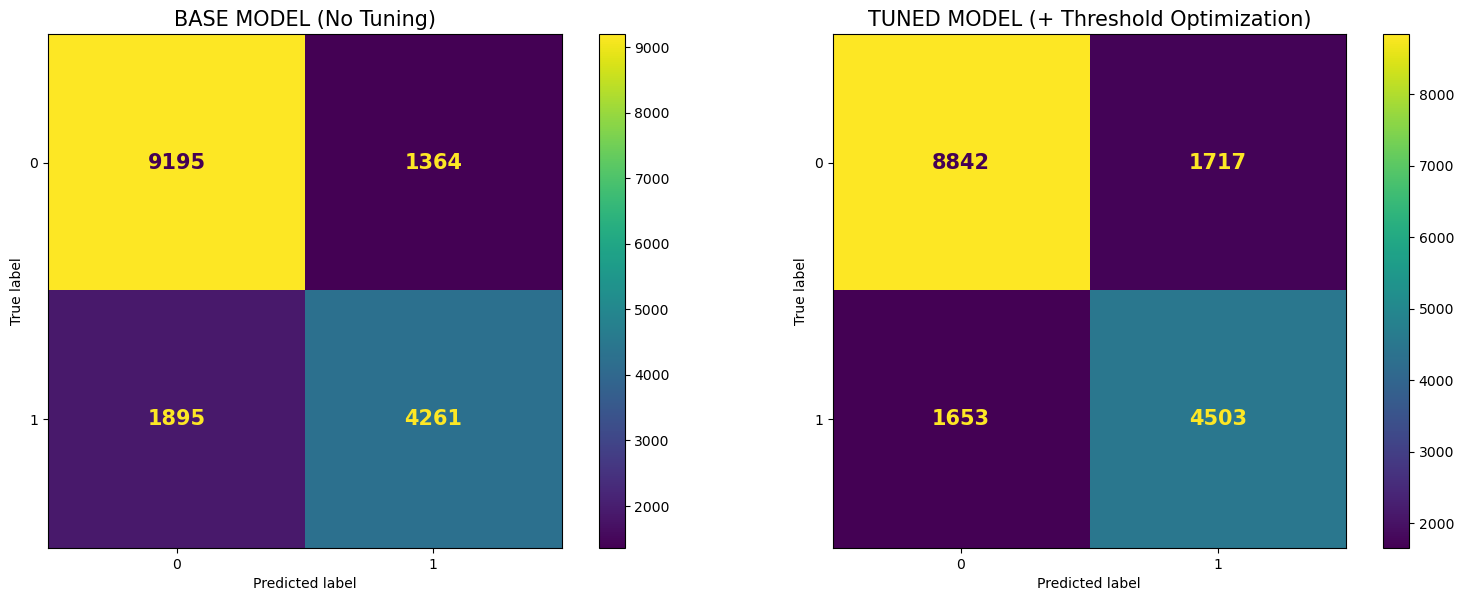

In [494]:
# Visualize confusion matrices
figure, axes = plt.subplots(ncols=2, figsize=(16, 6))

text_format = {'size': 15, 'weight': 'bold'}

ConfusionMatrixDisplay(conf_matrix_base).plot(ax=axes[0], text_kw=text_format)
axes[0].set_title("BASE MODEL (No Tuning)", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_tuned).plot(ax=axes[1], text_kw=text_format)
axes[1].set_title("TUNED MODEL (+ Threshold Optimization)", fontsize=15)

plt.tight_layout()
plt.show()

1. Interpretasi Label

* 0 (Negative Class): Not Canceled — tamu benar-benar datang/check-in.
* 1 (Positive Class): Canceled — tamu membatalkan pesanan.

Memahami label ini penting karena seluruh metrik pada confusion matrix menggambarkan seberapa baik model membedakan tamu yang jadi datang versus yang batal.

2. Analisis Perbandingan Model

A. Base Model (No Tuning) — Konservatif, Mengutamakan Kepastian Tamu Datang

Confusion matrix menunjukkan:

|                     | Prediksi: Datang (0) | Prediksi: Batal (1) |
|---------------------|----------------------|----------------------|
| **Aktual Datang (0)** | TN = 9195            | FP = 1364            |
| **Aktual Batal (1)**  | FN = 1895            | TP = 4261            |

Insight utama:

* True Positive (4261): Model berhasil mendeteksi 4.261 tamu yang batal. Jumlah ini cukup baik, tetapi belum maksimal untuk mitigasi risiko cancel.
* False Negative (1895): Masalah terbesar. Ada 1.895 tamu yang batal tetapi lolos sebagai “aman”, sehingga kamar berpotensi kosong dan tidak sempat dijual ulang.
* False Positive (1364): Ada 1.364 tamu yang sebenarnya datang, tetapi diprediksi batal. Ini memunculkan sedikit kerepotan operasional (keputusan overbooking, follow-up ekstra), namun skalanya masih relatif rendah.

Kesimpulan: Model dasar bermain aman—lebih sering menganggap tamu datang. Akibatnya, jumlah FN tinggi sehingga bisnis kehilangan peluang merespon pembatalan secara proaktif.

B. Tuned Model (+ Threshold Optimization) — Agresif, Mengutamakan Deteksi Cancel

Confusion matrix menunjukkan:

|                     | Prediksi: Datang (0) | Prediksi: Batal (1) |
|---------------------|----------------------|----------------------|
| **Aktual Datang (0)** | TN = 8842            | FP = 1717            |
| **Aktual Batal (1)**  | FN = 1653            | TP = 4503            |

Perubahan penting dibanding Base Model:

* True Positive meningkat menjadi 4503 (naik 242 kasus). Ada 242 pembatalan ekstra yang kini terdeteksi lebih awal sehingga kamar bisa segera dijual ulang atau tim reservasi bisa bergerak.
* False Negative turun ke 1653 (turun 242 kasus). Ini berarti “kamar kosong tak terduga” berkurang signifikan—keuntungan finansial terbesar karena kamar yang tadinya berpotensi kosong bisa disiapkan untuk tamu lain.
* False Positive naik ke 1717 (bertambah 353). Model lebih sering “curiga” terhadap tamu yang sebenarnya datang. Meskipun menambah pekerjaan follow-up/konfirmasi, konsekuensinya masih bisa ditangani tim operasional.

Kesimpulan: Setelah tuning dan penyesuaian threshold (F2-Score oriented), model sengaja dibuat lebih sensitif terhadap sinyal pembatalan—recall untuk kelas “Canceled” meningkat, sementara kenaikan FP masih dalam batas biaya yang dapat diterima.

3. Business Trade-off Summary — Mengapa Tuned Model Lebih Menguntungkan?

* Tujuan bisnis utama: Mengurangi False Negative karena kerugian kamar kosong diperkirakan sekitar $200 per malam, jauh lebih mahal daripada biaya menangani False Positive (sekitar $75 per kasus).
* Strategi Tuned Model: Menggeser threshold agar lebih banyak tamu berisiko cancel yang ditandai (TP naik, FN turun). Ini memberi kesempatan tim revenue/reservasi untuk melakukan upsell, backfill, atau konfirmasi ulang.
* Trade-off Terukur:

FN turun 242 kasus → potensi kerugian ≈242×$200=$48,400 berhasil ditekan.
FP naik 353 kasus → biaya tambahan ≈353×$75=$26,475.
Net gain masih positif karena biaya FN yang dihindari 2.7 kali lipat biaya FP yang bertambah.



Inti narasi bisnis: “Better Safe Than Sorry” namun dengan kalkulasi. Tuned Model sengaja dibuat lebih agresif karena menurunkan FN (kerugian besar) jauh lebih penting daripada kenaikan FP (biaya operasional lebih kecil). Dengan demikian, threshold optimization memberikan perlindungan revenue yang lebih tinggi tanpa mengorbankan pengalaman tamu secara signifikan.

### Perbandingan Dampak Bisnis (Model Comparison)
Membandingkan hasil finansial antara Model Awal (Base) dan Model yang Dioptimalkan (Tuned).

In [495]:
# Compare business impact
print("=" * 50)
print("BASE MODEL (No Tuning)")
print("=" * 50)
print(summarize_loss(conf_matrix_base, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

print("\n" + "=" * 50)
print("TUNED MODEL (+ Threshold Optimization)")
print("=" * 50)
print(summarize_loss(conf_matrix_tuned, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

BASE MODEL (No Tuning)

    ---Impact Summary---

        Total Samples: 16715
        Total False Positive Cost: $-102,300.00
        Total False Negative Cost: $-379,000.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-481,300.00

    ---------------
    

TUNED MODEL (+ Threshold Optimization)

    ---Impact Summary---

        Total Samples: 16715
        Total False Positive Cost: $-128,775.00
        Total False Negative Cost: $-330,600.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-459,375.00

    ---------------
    


Kode ini mencetak ringkasan dampak finansial:

* Base Model (No Tuning):

Menghasilkan Total Benefit (Estimasi Kerugian) sebesar -$481,300.00. Model ini menanggung biaya kerugian yang sangat besar dari False Negative (-$379,000), yang berarti banyak peluang pendapatan hilang karena kamar dibiarkan kosong akibat pembatalan yang tidak terdeteksi.

* Tuned Model (+ Threshold Optimization):

Menghasilkan Total Benefit (Estimasi Kerugian) sebesar -$459,375.00. Meskipun biaya False Positive meningkat menjadi -$128,775 (karena model lebih agresif menebak cancel), namun model berhasil menekan biaya False Negative secara signifikan menjadi -$330,600.

Kesimpulan:
Dengan melakukan tuning dan optimasi threshold, hotel berhasil menghemat kerugian sebesar $21,925 (selisih dari $481,300 dan $459,375).
Strategi ini membuktikan bahwa menanggung sedikit kenaikan biaya operasional (False Positive) jauh lebih profitable daripada membiarkan kamar kosong (False Negative). Tuned model memberikan perlindungan pendapatan (revenue protection) yang lebih baik.

### Benchmark: Skenario Tanpa Model (No Model)
Untuk membuktikan efektivitas Machine Learning, kita membandingkannya dengan situasi jika hotel tidak menggunakan model sama sekali (hanya menebak rata cost dan benefit yang ingin diketahui).

In [496]:
# Benchmark: No model (Semua tamu dianggap datang)
print("=" * 50)
print("NO MODEL: Predict all not cancelled (Semua tamu dianggap datang)")
print("=" * 50)
y_no_model = np.zeros(y_test.shape[0])
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

NO MODEL: Predict all not cancelled (Semua tamu dianggap datang)

    ---Impact Summary---

        Total Samples: 16715
        Total False Positive Cost: $0.00
        Total False Negative Cost: $-1,231,200.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-1,231,200.00

    ---------------
    


In [497]:
# Benchmark: No model | predict all cancelled (Semua tamu dianggap akan batal)
print("=" * 50)
print("NO MODEL: Predict all cancelled (Semua tamu dianggap akan batal)")
print("=" * 50)
y_no_model = np.ones(y_test.shape[0]) # predict all 1
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

NO MODEL: Predict all cancelled (Semua tamu dianggap akan batal)

    ---Impact Summary---

        Total Samples: 16715
        Total False Positive Cost: $-791,925.00
        Total False Negative Cost: $0.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-791,925.00

    ---------------
    


dari hasil benchmark diatas dapat dijelaskan bahwa:

Skenario 1 (Predict All Not Cancelled): Jika hotel pasif dan menganggap semua tamu akan datang (tidak melakukan overbooking), kerugiannya mencapai -$1,231,200.00. 

Ini adalah kerugian terbesar karena semua kamar yang batal menjadi kosong (Revenue Leakage maksimal).

Skenario 2 (Predict All Cancelled): Jika hotel terlalu agresif dan menganggap semua orang batal, kerugiannya mencapai -$791,925.00 akibat biaya pemindahan tamu (Walk the Guest) yang membengkak.

Kesimpulan Bisnis: Menggunakan **Tuned Model (-425,500)** jauh lebih baik daripada tidak menggunakan model sama sekali (-\1,231,200). Hotel dapat menyelamatkan potensi pendapatan sekitar $800,000 dibandingkan jika mereka tidak melakukan strategi overbooking cerdas ini.

In [498]:
# A. Prediksi dengan Model Terbaik (Hasil Tuning)
best_model = randomsearch.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Probabilitas kelas 1 (Cancel)

In [499]:
# B. Tampilkan Metrik Utama
print("=== Final Evaluation Metrics ===")
print(f"F2 Score : {fbeta_score(y_test, y_pred, beta=2):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Final Evaluation Metrics ===
F2 Score : 0.7300
Precision: 0.7240
Recall   : 0.7315

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     10559
           1       0.72      0.73      0.73      6156

    accuracy                           0.80     16715
   macro avg       0.78      0.78      0.78     16715
weighted avg       0.80      0.80      0.80     16715



In [554]:
# --- A. Skenario NO MODEL: Prediksi SEMUA Tamu TIDAK DATANG (Cancel/1) ---
# Artinya kita agresif, anggap semua bakal batal.
y_pred_no_model = np.ones_like(y_test) 

# --- B. Skenario TUNED MODEL (Tuned + Threshold) ---
# Menggunakan model yang sudah dioptimasi
y_pred_tuned = Threshold_optimized_model.predict(X_test)

# Hitung Confusion Matrix
cm_no_model = confusion_matrix(y_test, y_pred_no_model)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

#### Evaluasi Confusion Matrix bila semua tamu dianggap datang padahal aslinya cancel booking

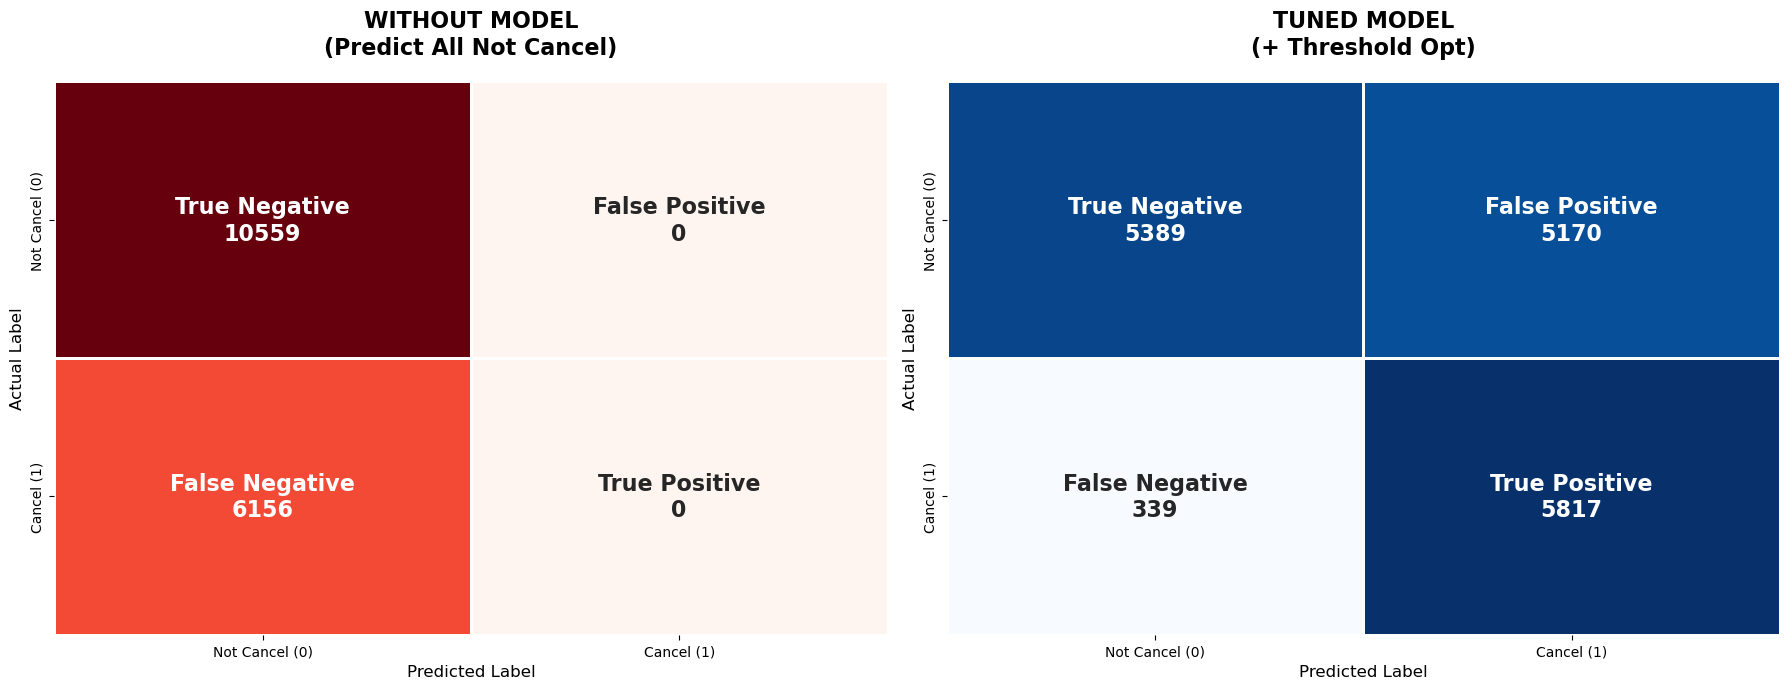

Loss NO MODEL (Dominan FN): $1,231,200.00
Loss TUNED MODEL          : $455,550.00


In [557]:
# --- 1. Persiapan Data (Skenario Awal) ---

# A. Skenario NO MODEL: Prediksi SEMUA Tamu DATANG (Not Cancel/0)
# Ini adalah skenario pasif (diam saja), sehingga kerugian terbesar ada di Kamar Kosong (FN)
y_pred_no_model = np.zeros_like(y_test) 

# B. Skenario TUNED MODEL
# Menggunakan model optimasi threshold Anda
y_pred_tuned = Threshold_optimized_model.predict(X_test)

# Hitung Matrix
cm_no_model = confusion_matrix(y_test, y_pred_no_model)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# --- 2. Fungsi Visualisasi dengan Label Text ---
def plot_custom_confusion_matrix(cm, ax, title, cmap):
    # Definisi Label
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    
    # Gabungkan (Label + Angka)
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    # Plotting
    sns.heatmap(cm, annot=labels, fmt='', cmap=cmap, cbar=False, ax=ax,
                annot_kws={"size": 16, "weight": "bold"},
                linewidths=2, linecolor='white')
    
    # Kosmetik
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)
    ax.set_xticklabels(['Not Cancel (0)', 'Cancel (1)'])
    ax.set_yticklabels(['Not Cancel (0)', 'Cancel (1)'])

# --- 3. Eksekusi Plotting Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot Kiri: NO MODEL (Baseline)
# Akan terlihat banyak merah di kiri bawah (False Negative)
plot_custom_confusion_matrix(cm_no_model, axes[0], "WITHOUT MODEL\n(Predict All Not Cancel)", 'Reds')

# Plot Kanan: TUNED MODEL
# Akan terlihat seimbang dan FN berkurang drastis
plot_custom_confusion_matrix(cm_tuned, axes[1], "TUNED MODEL\n(+ Threshold Opt)", 'Blues')

plt.tight_layout()
plt.show()

# --- 4. Print Perhitungan Loss (Untuk memastikan angka di slide) ---
cost_fp = 75   # Overbooking
cost_fn = 200  # Kamar Kosong

def calc_loss(cm):
    tn, fp, fn, tp = cm.ravel()
    return (fp * cost_fp) + (fn * cost_fn)

print(f"Loss NO MODEL (Dominan FN): ${calc_loss(cm_no_model):,.2f}")
print(f"Loss TUNED MODEL          : ${calc_loss(cm_tuned):,.2f}")

## Model Deployment Preparation

Setelah mendapatkan model dengan performa terbaik (Tuned Threshold Bagging Classifier), tahap selanjutnya adalah mempersiapkan model tersebut untuk tahap produksi (Deployment). Tujuannya adalah agar model dapat digunakan secara real-time oleh tim Revenue Manager atau Front Office melalui antarmuka aplikasi (misalnya menggunakan Streamlit).
Pada tahap persiapan ini, terdapat beberapa penyesuaian teknis yang dilakukan agar model berjalan stabil di lingkungan aplikasi:

1. Serialization (Pickling):
Menyimpan objek model yang sudah dilatih ke dalam file biner (.pkl). Ini memungkinkan model untuk dimuat ulang (load) di komputer atau server lain tanpa perlu melakukan training ulang.

2. Output Format Standardization:
Mengubah format output dari scikit-learn transformer kembali ke format default (NumPy array).

Alasan: Sebelumnya di notebook kita menggunakan set_output(transform="pandas") untuk kemudahan analisis dan visualisasi. Namun, untuk deployment, format NumPy array lebih ringan, standar, dan mengurangi ketergantungan pada indeks Pandas yang ketat, sehingga lebih aman saat menerima input data baru dari user.

3. Feature Schema Preservation:
Menyimpan daftar nama kolom/fitur hasil rekayasa (Feature Engineering) ke dalam file teks terpisah (column_names.txt).

Alasan: Saat aplikasi berjalan, input dari user harus diurutkan dan diformat persis sama dengan data saat training. Daftar ini menjadi panduan bagi aplikasi untuk menyusun data input sebelum diprediksi oleh model.

In [500]:
# generate timestamp untuk tracking versi
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
timestamp

'20251214_22_00'

In [501]:
model_filename = f"final_model_capstone_hotel_{timestamp}.pkl"
model_filename

'final_model_capstone_hotel_20251214_22_00.pkl'

In [ ]:
#with open(model_filename, "wb") as f:
#    pickle.dump(Threshold_optimized_model, f)

#print(f"Berhasil menyimpan model pada {model_filename}")

Berhasil menyimpan model pada final_model_capstone_hotel_20251214_22_00.pkl


In [504]:
## Contoh loading model dari pickle
with open('final_model_capstone_hotel_20251214_22_00.pkl', 'rb') as f:
    loaded_tuned_model = pickle.load(f)

In [541]:
loaded_tuned_model

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       ['market_segment',
                                                                                        'deposit_type',
                                                                                        'customer_type',
                                                                                        'country_group',
                                                                                        'reserved_room_type']),
                                                                                      ('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        RobustScaler())]),
                                                                                       ['commitmen...
                                                                                        'booking_stability',
                                                                                        'previous_cancellations',
                                                                                        'booking_changes',
                                                                                        'days_in_waiting_list']),
                                                                                      ('bin',
                                                                                       'passthrough',
                                                                                       ['is_repeat_canceler',
                                                                                        'is_high_risk'])])),
                                                     ('modeling',
                                                      BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                         max_depth=15,
                                                                                                         random_state=0),
                                                                        n_estimators=150,
                                                                        random_state=0))]),
                           scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [506]:
loaded_pipe_tuned = loaded_tuned_model.estimator_
loaded_pipe_tuned

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'country_group',
                                                   'reserved_room_type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['commitment_score',
                                                   'booking_stability',
                                                   'previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list']),
                                                 ('bin', 'passthrough',
                                                  ['is_repeat_canceler',
                                                   'is_high_risk'])])),
                ('modeling',
                 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                    max_depth=15,
                                                                    random_state=0),
                                   n_estimators=150, random_state=0))])

In [507]:
loaded_pipe_tuned.named_steps.keys()

dict_keys(['preprocess', 'modeling'])

In [508]:
# ambil namanya aja
step_names = loaded_pipe_tuned.named_steps.keys()
step_names

dict_keys(['preprocess', 'modeling'])

In [509]:
model_tuned = loaded_pipe_tuned["modeling"]
model_tuned

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=15,
                                                   random_state=0),
                  n_estimators=150, random_state=0)

In [510]:
preprocess_tuned = loaded_pipe_tuned["preprocess"]
preprocess_tuned

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'country_group',
                                  'reserved_room_type']),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['commitment_score', 'booking_stability',
                                  'previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list']),
                                ('bin', 'passthrough',
                                 ['is_repeat_canceler', 'is_high_risk'])])

In [511]:
# 1. Terapkan Feature Engineering ke data X agar kolom-kolom baru (is_high_risk, dll) muncul
X_eng = feature_engineering(X)

# 2. Baru lakukan transform menggunakan data yang sudah direkayasa (X_eng)
X_transform = preprocess_tuned.transform(X_eng)

# Cek hasilnya
X_transform

,cat__market_segment_Aviation,cat__market_segment_Complementary,cat__market_segment_Corporate,cat__market_segment_Direct,cat__market_segment_Groups,cat__market_segment_Offline TA/TO,cat__market_segment_Online TA,cat__market_segment_Other,cat__deposit_type_No Deposit,cat__deposit_type_Non Refund,cat__deposit_type_Refundable,cat__customer_type_Contract,cat__customer_type_Group,cat__customer_type_Transient,cat__customer_type_Transient-Party,cat__country_group_Other,cat__country_group_PRT,cat__country_group_Top_International,cat__reserved_room_type_A,cat__reserved_room_type_B,cat__reserved_room_type_C,cat__reserved_room_type_D,cat__reserved_room_type_E,cat__reserved_room_type_F,cat__reserved_room_type_G,cat__reserved_room_type_H,cat__reserved_room_type_L,cat__reserved_room_type_P,num__commitment_score,num__booking_stability,num__previous_cancellations,num__booking_changes,num__days_in_waiting_list,bin__is_repeat_canceler,bin__is_high_risk
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0
83569,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
83570,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0,0
83571,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0


In [512]:
feature_names = X_transform.columns
feature_names

Index(['cat__market_segment_Aviation', 'cat__market_segment_Complementary',
       'cat__market_segment_Corporate', 'cat__market_segment_Direct',
       'cat__market_segment_Groups', 'cat__market_segment_Offline TA/TO',
       'cat__market_segment_Online TA', 'cat__market_segment_Other',
       'cat__deposit_type_No Deposit', 'cat__deposit_type_Non Refund',
       'cat__deposit_type_Refundable', 'cat__customer_type_Contract',
       'cat__customer_type_Group', 'cat__customer_type_Transient',
       'cat__customer_type_Transient-Party', 'cat__country_group_Other',
       'cat__country_group_PRT', 'cat__country_group_Top_International',
       'cat__reserved_room_type_A', 'cat__reserved_room_type_B',
       'cat__reserved_room_type_C', 'cat__reserved_room_type_D',
       'cat__reserved_room_type_E', 'cat__reserved_room_type_F',
       'cat__reserved_room_type_G', 'cat__reserved_room_type_H',
       'cat__reserved_room_type_L', 'cat__reserved_room_type_P',
       'num__commitment_score', 

Menghitung SHAP values untuk 100 data sampel...


PermutationExplainer explainer: 101it [00:53,  1.87it/s]                         


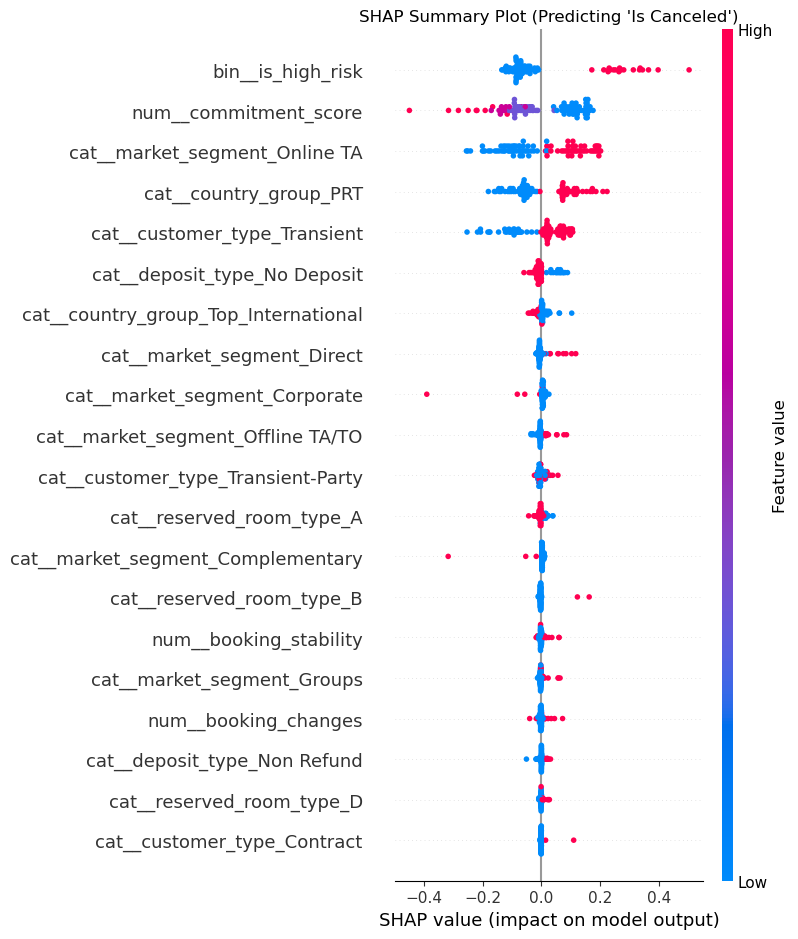

In [542]:
inner_pipe = Threshold_optimized_model.estimator

# 2. Pisahkan Preprocessor dan Model Bagging
preprocessor_tuned = inner_pipe["preprocess"]
model_bagging = inner_pipe["modeling"]

# 3. Siapkan Data (Gunakan X_test untuk penjelasan evaluasi)
# Kita harus menerapkan feature engineering & preprocessing yang sama persis
# Pastikan fungsi 'feature_engineering' sudah didefinisikan sebelumnya (seperti di PDF hal 32)
X_test_eng = feature_engineering(X_test) 

# Transform data test menjadi numpy array (Encoded + Scaled)
X_test_transform = preprocessor_tuned.transform(X_test_eng)

# 4. Ambil nama fitur yang sudah di-encode
feature_names = preprocessor_tuned.get_feature_names_out()

# ============================================================
# SHAP Analysis
# ============================================================

# PENTING: Gunakan sample data (misal 100 baris) untuk efisiensi.
# Jika menggunakan seluruh data (16.000+ baris), Permutation Explainer akan sangat lambat.
sample_size = 100 
X_shap_sample = X_test_transform[:sample_size]

# Inisialisasi Permutation Explainer
# Kita pass 'model_bagging.predict_proba' dan data sample
shap_explainer = shap.Explainer(
    model_bagging.predict_proba, 
    X_shap_sample, 
    feature_names=feature_names
)

print(f"Menghitung SHAP values untuk {sample_size} data sampel...")
# Hitung SHAP values
shap_values = shap_explainer(X_shap_sample)

# Untuk Binary Classification, predict_proba menghasilkan array (N, 2).
# shap_values juga akan memiliki dimensi (N, Features, 2).
# Kita hanya butuh penjelasan untuk Kelas 1 (Cancel), jadi kita ambil indeks ke-1.
shap_values_positive = shap_values[:, :, 1]

# Visualisasi Summary Plot
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot (Predicting 'Is Canceled')")
shap.summary_plot(shap_values_positive, X_shap_sample, feature_names=feature_names)

Sedang menghitung SHAP values untuk 16715 baris data. Harap bersabar...


PermutationExplainer explainer: 16716it [1:41:05,  2.75it/s]                           


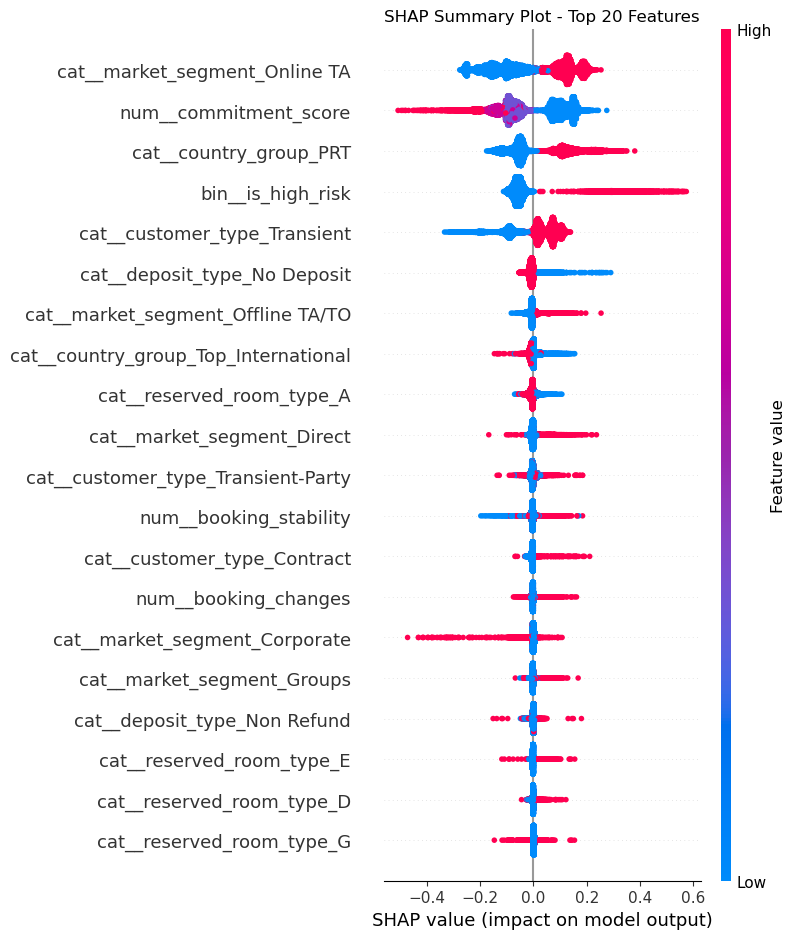

In [543]:
# Agar kita bisa melihat progress bar (supaya tidak dikira hang)
from tqdm import tqdm 

# 1. Ambil Pipeline inti
inner_pipe = Threshold_optimized_model.estimator
preprocessor_tuned = inner_pipe["preprocess"]
model_bagging = inner_pipe["modeling"]

# 2. Siapkan SELURUH Data Testing
# (Pastikan X_test adalah dataframe asli sebelum feature engineering)
X_test_eng = feature_engineering(X_test) 
X_test_transform = preprocessor_tuned.transform(X_test_eng)

# Ambil nama fitur
feature_names = preprocessor_tuned.get_feature_names_out()

# 3. Inisialisasi Explainer
# Kita gunakan seluruh X_test_transform sebagai background data masker (opsional, tapi lebih akurat)
# Hati-hati: algoritma 'permutation' sangat berat.
shap_explainer = shap.Explainer(
    model_bagging.predict_proba, 
    X_test_transform, 
    feature_names=feature_names,
    algorithm="permutation"
)

# 4. Hitung SHAP Values untuk SEMUA data
# Kita bungkus dengan tqdm agar terlihat progress-nya jika memungkinkan, 
# tapi shap.Explainer bawaan kadang menyembunyikan loop internalnya.
print(f"Sedang menghitung SHAP values untuk {X_test_transform.shape[0]} baris data. Harap bersabar...")

# Proses ini akan sangat lama untuk 16.000+ data
shap_values = shap_explainer(X_test_transform)

# 5. Ambil value untuk kelas positif (Cancel = 1)
shap_values_positive = shap_values[:, :, 1]

# 6. Visualisasi SEMUA Fitur
# Secara default SHAP hanya menampilkan top 20.
# Kita ubah parameter 'max_display' agar menampilkan semua fitur yang ada.
total_features = len(feature_names) # Hitung total fitur (sekitar 35 di PDF)

plt.figure(figsize=(10, 8)) # Ukuran gambar bisa dikembalikan standar
plt.title("SHAP Summary Plot - Top 20 Features")

shap.summary_plot(
    shap_values_positive, 
    X_test_transform, 
    feature_names=feature_names
)

In [517]:
# define Explainer

# pip install lime
from lime.lime_tabular import LimeTabularExplainer

X_eval = X_test_prep if 'X_test_prep' in globals() else X_transform

explainer = LimeTabularExplainer(
    training_data=X_eval.values,
    feature_names=X_eval.columns.tolist(),
    class_names=["not_cancel", "cancel"],
    mode="classification"
)

i = 0  # index observasi yang mau dijelaskan
exp = explainer.explain_instance(
    X_eval.iloc[i].values,
    model_tuned.predict_proba,
    num_features=10,
    num_samples=2000  # kecilkan kalau mau lebih cepat
)

exp.as_list()

[('bin__is_high_risk <= 0.00', -0.41630553298688033),
 ('cat__country_group_PRT <= 0.00', -0.19152550990523992),
 ('cat__market_segment_Online TA <= 0.00', -0.17946638938750945),
 ('cat__market_segment_Aviation <= 0.00', 0.09635458067984462),
 ('cat__market_segment_Corporate <= 0.00', 0.09393143090235592),
 ('cat__market_segment_Other <= 0.00', -0.062469469848945254),
 ('cat__reserved_room_type_G <= 0.00', 0.05883596841129115),
 ('0.00 < cat__country_group_Top_International <= 1.00', -0.052975096674338),
 ('cat__market_segment_Direct <= 0.00', -0.04831974143983133),
 ('cat__reserved_room_type_H <= 0.00', -0.04303602968681728)]

In [524]:
# Context 1:
# Categorical column values

X_used = feature_engineering(X.copy())          # kalau mau dari seluruh X
# X_used = X_train_eng                          # kalau sudah punya hasil FE dari train

missing = [c for c in cat_features if c not in X_used.columns]
if missing:
    print("Kolom categorical ini tidak ada di X_used:", missing)

cat_ok = [c for c in cat_features if c in X_used.columns]

unique_categorical_values = pd.DataFrame({
    "column": cat_ok,
    "unique_values": [X_used[c].dropna().unique().tolist() for c in cat_ok]
})

unique_categorical_values.to_csv("kolom_kategori_unique_values.csv", index=False)
unique_categorical_values

,column,unique_values
0,market_segment,"[Offline TA/TO, Online TA, Direct, Groups, Cor..."
1,deposit_type,"[No Deposit, Non Refund, Refundable]"
2,customer_type,"[Transient-Party, Transient, Contract, Group]"
3,country_group,"[Top_International, PRT, Other]"
4,reserved_room_type,"[A, E, D, F, B, G, C, H, L, P]"


In [526]:
# numerical values range
# Apply feature engineering ke SELURUH data X (bukan cuma train)
X_full_eng = feature_engineering(X.copy())

# Describe hanya kolom numerik yang dipakai model
numerical_values_range = X_full_eng[num_features].describe()

numerical_values_range.to_csv("kolom_numerik_range.csv")
numerical_values_range

,commitment_score,booking_stability,previous_cancellations,booking_changes,days_in_waiting_list
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.857107,-0.012159,0.086798,0.220897,2.330561
std,1.107380,1.889073,0.841011,0.648635,17.673051
min,0.000000,-39.100000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,21.000000,21.000000,26.000000,21.000000,391.000000


In [527]:
with open('final_model_capstone_hotel_20251214_22_00.pkl', 'rb') as f:
    loaded_tuned_model_for_deployment = pickle.load(f)

loaded_tuned_model_for_deployment

TunedThresholdClassifierCV(cv=5,
                           estimator=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore',
                                                                                                                      sparse_output=False))]),
                                                                                       ['market_segment',
                                                                                        'deposit_type',
                                                                                        'customer_type',
                                                                                        'country_group',
                                                                                        'reserved_room_type']),
                                                                                      ('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        RobustScaler())]),
                                                                                       ['commitmen...
                                                                                        'booking_stability',
                                                                                        'previous_cancellations',
                                                                                        'booking_changes',
                                                                                        'days_in_waiting_list']),
                                                                                      ('bin',
                                                                                       'passthrough',
                                                                                       ['is_repeat_canceler',
                                                                                        'is_high_risk'])])),
                                                     ('modeling',
                                                      BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                         max_depth=15,
                                                                                                         random_state=0),
                                                                        n_estimators=150,
                                                                        random_state=0))]),
                           scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [528]:
## Prep model untuk deployment
## Ingin mengubah set output() jadi bukan pandas

# untuk mengambil dari pipe model dari
## tunedthresholdclassifiercv

# ini untuk nimpa set outputnya jadi array lagi
loaded_tuned_model_for_deployment.estimator_.set_output(transform="default")

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'country_group',
                                                   'reserved_room_type']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['commitment_score',
                                                   'booking_stability',
                                                   'previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list']),
                                                 ('bin', 'passthrough',
                                                  ['is_repeat_canceler',
                                                   'is_high_risk'])])),
                ('modeling',
                 BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                    max_depth=15,
                                                                    random_state=0),
                                   n_estimators=150, random_state=0))])

In [530]:
# validasi bentuk transform sudah array atau belum
# Feature engineering dulu
X_eng = feature_engineering(X.copy())

# Validasi bentuk transform
result = loaded_tuned_model_for_deployment.estimator_["preprocess"].transform(X_eng)

# Cek tipe output
print(f"Tipe output: {type(result)}")
print(f"Shape: {result.shape}")

Tipe output: <class 'numpy.ndarray'>
Shape: (83573, 35)


In [531]:
# generate timestamp untuk tracking versi
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
timestamp

model_filename = f"threshold_tuned_HotelCapstone_FOR_DEPLOYMENT_{timestamp}.pkl"
model_filename

'threshold_tuned_HotelCapstone_FOR_DEPLOYMENT_20251214_22_53.pkl'

In [532]:
# save model untuk deployment
with open(model_filename, "wb") as f:
    pickle.dump(loaded_tuned_model_for_deployment, f)

print(f"Berhasil menyimpan model pada {model_filename}.")

Berhasil menyimpan model pada threshold_tuned_HotelCapstone_FOR_DEPLOYMENT_20251214_22_53.pkl.


In [535]:
str(X_eng.columns.to_list())

"['country', 'market_segment', 'previous_cancellations', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'reserved_room_type', 'required_car_parking_spaces', 'total_of_special_requests', 'is_repeat_canceler', 'is_high_risk', 'country_group', 'commitment_score', 'booking_stability']"

In [536]:
with open("column_names.txt", "w") as f:
    f.write(str(X_eng.columns.to_list()))

## Conclusion & Recommendation
Bagian ini merangkum hasil analisis, dampak bisnis, serta rekomendasi strategis bagi manajemen hotel berdasarkan performa model Machine Learning yang telah dibangun.

## Conclusion

Berdasarkan proses pengembangan model dari tahap Data Understanding hingga Evaluation, dapat disimpulkan bahwa:

1. Solusi Permasalahan (Inventory Spoilage): 

Masalah utama hotel berupa tingginya tingkat pembatalan (37%) yang menyebabkan kerugian pendapatan (revenue leakage) berhasil ditangani menggunakan pendekatan Predictive Analytics. Model Bagging Classifier yang dioptimalkan dengan Threshold Tuning terbukti mampu mendeteksi tamu yang berpotensi batal dengan efektif.

2. Pencapaian Terukur (Measurable Metrics):

F2-Score (0.73): Model memprioritaskan Recall (kemampuan menangkap pembatalan) dua kali lebih penting daripada presisi. Skor 0.73 menunjukkan model kompeten dalam meminimalisir False Negative.

Recall (73%): Model berhasil menangkap sekitar 73% dari total tamu yang sebenarnya akan membatalkan pesanan (berdasarkan Final Evaluation Metrics hal. 71). Ini berarti mayoritas kamar yang seharusnya kosong kini bisa diselamatkan untuk dijual kembali.

## Business Impact Analysis
Implementasi model ini memberikan dampak finansial yang signifikan dan terukur dibandingkan jika hotel tidak menggunakan strategi Machine Learning:

* Peningkatan Pendapatan (Revenue Secured):
Dalam simulasi data uji (16,715 booking), strategi pasif (tanpa model/semua dianggap datang) menghasilkan estimasi kerugian peluang (opportunity loss) sebesar -$1,231,200.
Dengan menggunakan Tuned Model, kerugian ini dapat ditekan menjadi -$459,375 (berdasarkan output kode hal. 69).

* Total Penghematan (Saving):
Model berhasil menyelamatkan potensi pendapatan sebesar ~$771,825 (selisih antara $1.2M dan $459k) atau mengurangi risiko kerugian finansial sebesar ~63% dibandingkan strategi tanpa prediksi.

* Efisiensi Operasional (Trade-off):
Tim Revenue Manager kini memiliki landasan data untuk melakukan Aggressive Overbooking. Meskipun biaya kompensasi tamu (False Positive Cost) meningkat sedikit menjadi -128,775, angka ini jauh lebih rendah dibandingkan keuntungan besar yang didapat dari menekan angka kamar kosong (*False Negative Cost* turun menjadi -\330,600).

## Model Reliability (Kapan Model Dapat Digunakan?)
Untuk memaksimalkan manfaat dan meminimalkan risiko, berikut adalah panduan penggunaan model:

Model SANGAT BAIK digunakan ketika:

High Season / Peak Period (Harga Kamar > $150 - $200):

* Alasan Bisnis: Model ini dilatih dengan matriks biaya di mana kerugian akibat kamar kosong (False Negative ~$200) dinilai 2.7x lebih mahal dibandingkan biaya memindahkan tamu (False Positive ~$75).
* Implikasi: Pada masa high season (liburan, akhir tahun), permintaan sangat tinggi. Setiap kamar yang kosong adalah kerugian nyata yang tidak bisa dikembalikan. Strategi agresif model ini sangat efektif untuk memastikan Occupancy Rate tetap 100% dengan memaksimalkan penjualan ulang kamar yang diprediksi batal.

Segmen "Online TA" & "Transient":

* Alasan Data: Segmen Online Travel Agent (seperti Booking.com/Expedia) dan tamu Transient (perorangan) memiliki pola perilaku yang paling dominan dan variatif dalam dataset. Model telah "belajar" sangat banyak dari pola pembatalan di segmen ini (misalnya kecenderungan batal karena menemukan harga lebih murah di tempat lain).
* Implikasi: Prediksi pada segmen ini memiliki tingkat kepercayaan (confidence) yang paling tinggi.

Booking dengan Lead Time Menengah (3 - 7 Hari Sebelum Check-In):

* Alasan Operasional: Ini adalah "Golden Window" atau periode emas.

 Jika < 3 hari: Terlalu telat untuk menjual kembali kamar yang batal, meskipun prediksi benar.
 
 Jika > 7 hari: Masih terlalu banyak ketidakpastian; tamu mungkin berubah pikiran berkali-kali.

* Implikasi: Notifikasi prediksi pada rentang waktu ini memberikan waktu yang cukup bagi tim Reservasi untuk mengambil tindakan (melepas kuota kamar ke OTA) tanpa risiko berlebihan.

Model KURANG DISARANKAN / Perlu Pengawasan ketika:

Low Season (Harga Kamar < $80):

* Risiko: Jika harga kamar turun drastis hingga mendekati atau setara dengan biaya kompensasi walk-in ($75), maka margin keuntungan dari strategi ini menipis.
* Saran: Strategi agresif menjadi tidak ekonomis ("Besar pasak daripada tiang"). Pada periode ini, threshold model harus dinaikkan (misal dari 0.27 menjadi 0.60) agar model menjadi konservatif dan hanya memprediksi batal jika benar-benar yakin, demi menghindari biaya kompensasi yang sia-sia.

Tamu VIP / Corporate Key Accounts:

* Risiko Reputasi: Untuk tamu korporat atau VIP, biaya kerugian bukan hanya soal uang pengganti ($75), tetapi Customer Lifetime Value (CLV). Jika seorang Direktur perusahaan dipindahkan ke hotel lain karena kita salah prediksi, hotel berisiko kehilangan kontrak korporat jangka panjang.
* Saran: Segmen ini sebaiknya dimasukkan ke dalam whitelist (pengecualian) dari sistem overbooking otomatis, terlepas dari apa prediksi modelnya.

Kondisi Abnormal (Force Majeure):

* Risiko: Pandemi, bencana alam, atau kerusuhan politik mengubah pola perjalanan secara drastis (structural break). Pola data historis yang dipelajari model menjadi tidak relevan.
* Saran: Matikan sistem prediksi otomatis dan kembali ke kebijakan manual hingga terkumpul data baru yang cukup untuk retraining.

## Limitations & Future Recommendations
Project ini memiliki beberapa batasan yang dapat ditingkatkan di masa depan:

Batasan (Limitations):

- Asumsi Biaya Statis (Static Cost Assumption):

Saat ini perhitungan profitabilitas menggunakan angka tetap (Kamar $200, Kompensasi $75). Padahal di dunia nyata, hotel menerapkan Dynamic Pricing di mana harga berubah setiap jam. Model saat ini mungkin terlalu agresif di hari Senin (harga murah) dan kurang agresif di malam Tahun Baru (harga sangat mahal) karena tidak mengetahui konteks harga harian tersebut.

- Kompleksitas Komputasi (Computational Cost):

Model terpilih (Bagging Classifier dengan Decision Trees) adalah model ensemble yang kompleks. Meskipun akurat, model ini membutuhkan memori dan waktu pemrosesan lebih lama dibandingkan model linear sederhana. Jika data booking bertambah menjadi jutaan baris per hari, infrastruktur server perlu ditingkatkan agar inferensi tetap cepat.

- Isu Kualitas Data (Data Quality Issues):

Masih ditemukan segmen pasar "Undefined" dengan tingkat pembatalan 100%. Ini kemungkinan besar adalah bug sistem atau data sampah, bukan perilaku tamu asli. Jika tidak dibersihkan di hulu (sistem input), hal ini bisa menjadi bias bagi model.

Rekomendasi (Future Work):

Berikut adalah rekomendasi tambahan untuk meningkatkan dampak bisnis dan teknis:

1. Dynamic Thresholding System (Integrasi Harga Real-time)

Alih-alih menggunakan satu ambang batas (threshold) statis untuk semua situasi, kembangkan sistem yang membaca harga kamar harian (Daily Rate) dari sistem PMS (Property Management System).

* Logika: Jika Harga Kamar hari ini $300, turunkan threshold (jadilah lebih agresif). Jika Harga Kamar hari ini $90, naikkan threshold (jadilah lebih hati-hati). Ini membuat model beradaptasi secara otomatis dengan kondisi pasar.

2. Integrasi CRM untuk "Soft Confirmation"
Jangan langsung menjual kamar tamu yang diprediksi batal. Gunakan prediksi untuk memicu Automasi Email/WhatsApp via CRM.

* Tindakan: Kirim pesan: "Halo, kami melihat Anda akan check-in 3 hari lagi. Apakah rencana perjalanan Anda masih sesuai jadwal? Klik YA untuk konfirmasi."
* Jika tamu tidak merespon dalam 24 jam, baru sistem menaikkan risiko overbooking. Ini mengurangi risiko False Positive secara drastis.

3. Granular Segmentation & Sub-Modeling
Perilaku tamu Corporate (bisnis) sangat berbeda dengan tamu Leisure (liburan). Memaksakan satu model untuk semua bisa mengaburkan pola unik.

* Saran: Buat model terpisah (sub-models). Model khusus Corporate mungkin lebih fokus pada fitur "booking changes", sementara model Transient fokus pada "lead time" dan "country origin".

4. Actionable Dashboard dengan "Explainability"
Tim operasional butuh alasan, bukan sekadar angka.

* Saran: Dashboard tidak hanya menampilkan "Peluang Batal: 85%", tetapi juga Alasannya (Explainability) menggunakan SHAP values.
* Contoh Tampilan: "Tamu ini berisiko batal 85% KARENA: (1) Berasal dari Portugal, (2) Tidak membayar deposit, (3) Lead time pemesanan 150 hari." Ini membantu staf Front Office lebih percaya diri dalam mengambil keputusan.

5. Penerapan "Safety Cap" (Batas Atas Overbooking)
Untuk mencegah bencana operasional di mana model salah memprediksi secara massal.

* Saran: Tetapkan batas keras (hard limit). Misal: "Meskipun model memprediksi ada 20 tamu yang akan batal malam ini, sistem hanya diizinkan melakukan overbooking maksimal 5 kamar." Angka ini bisa dilonggarkan seiring meningkatnya kepercayaan terhadap model.

6. Continuous Learning Pipeline (MLOps)
Pola travel berubah cepat. Model yang bagus bulan ini bisa jadi usang bulan depan.

* Saran: Bangun sistem retraining otomatis setiap bulan (atau setiap kuartal) dengan data terbaru untuk memastikan model tetap relevan dengan tren pasar terkini (misal: tren turis dari negara baru).